In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cosine
from matplotlib.animation import FuncAnimation, writers
import matplotlib.colors as mcolors

# Helper Functions


In [52]:

def angle_between(v1, v2):
    """Calculate the angle (in degrees) between two 3D vectors."""
    dot_val = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 * norm_v2 < 1e-12:
        return 0.0
    cos_theta = np.clip(dot_val / (norm_v1 * norm_v2), -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def normalize_quaternion(q):
    """
    Normalize a quaternion to unit length.
    q: array-like [w, x, y, z]
    """
    q = np.asarray(q, dtype=float)
    return q / np.linalg.norm(q)

def quaternion_conjugate(q):
    """
    Compute the conjugate of a quaternion.
    q: array-like [w, x, y, z]
    returns [w, -x, -y, -z]
    """
    w, x, y, z = q
    return np.array([w, -x, -y, -z], dtype=float)

def quaternion_multiply(q1, q2):
    """
    Hamilton product of two quaternions.
    q1, q2: array-like [w, x, y, z]
    returns q1 ⊗ q2
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z], dtype=float)

def compute_relative_quaternion(q_ref, q_2):
    """
    Compute the relative quaternion q_rel = q_ref^{-1} ⊗ q_2.
    relative q_ref wrt q_2
    q_ref, q_2: array-like [w, x, y, z]
    returns q_rel normalized to unit length.
    """
    # Normalize inputs
    q_s = normalize_quaternion(q_ref)
    q_a = normalize_quaternion(q_2)
    # Inverse of a unit quaternion is its conjugate
    q_s_inv = quaternion_conjugate(q_s)
    # Relative rotation
    q_rel = quaternion_multiply(q_s_inv, q_a)
    # Normalize result to guard against numerical drift
    return normalize_quaternion(q_rel)

def compute_relative_angle(q_rel):
    """
    Compute the rotation angle θ (in radians) represented by a unit quaternion.

    Parameters
    ----------
    q_rel : array-like of shape (4,)
        The relative quaternion [w, x, y, z].

    Returns
    -------
    theta : float
        The rotation angle θ in radians, in [0, π].
    """
    # Convert to NumPy array and ensure float type
    q = np.asarray(q_rel, dtype=float)
    # Normalize to guard against drift
    q /= np.linalg.norm(q)
    w = np.clip(q[0], -1.0, 1.0)  # scalar part

    # Method 1: using arccos
    theta = 2 * np.arccos(w)   # angle in radians

    # Alternative (more stable for small angles):
    # v_norm = np.linalg.norm(q[1:])
    # theta = 2 * np.arctan2(v_norm, w)
    
    theta = np.degrees(theta)   # convert to degrees

    return theta

# Testing 3 IMUs configuration


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from scipy.spatial.transform import Rotation as R
import os

folder_name = "change_wrt_global"
folder_path = os.path.join("./DataLogger", folder_name)
angles = ["Back", "Shoulder_Flex_Ext","Shoulder_Add_Abd", "Shoulder_Rotation", "Elbow_Flex_Ext", "Hand_ROM"]
ANGLE_TO_DISPLAY = angles[2]

# Global Variables
N_FIRST_REF_FRAMES = 150
fps = 60
USER_HEIGHT = 1.75

files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
imu_data = {}
for file in files:
    parts = file.split("_")
    imu_id = parts[0]
    if "quaternion" not in file:
        continue
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    if "timestamp" not in df.columns:
        if "Time" in df.columns:
            df.rename(columns={"Time": "timestamp"}, inplace=True)
        else:
            continue
    imu_data.setdefault(imu_id, {})["quaternion_log"] = df.sort_values("timestamp")

processed_data = {imu: data["quaternion_log"] for imu, data in imu_data.items() if "quaternion_log" in data}
num_frames = min(len(df) for df in processed_data.values())

imu_ids = ['IMU-6', 'IMU-5', 'IMU-4', 'IMU-3', 'IMU-2', 'IMU-1']
ROOT_ID = 'ROOT'
lengths = {
    'IMU-6': 0.08 * USER_HEIGHT,
    'IMU-5': 0.14 * USER_HEIGHT,
    'IMU-4': 0.09 * USER_HEIGHT,
    'IMU-3': 0.186 * USER_HEIGHT,
    'IMU-2': 0.145 * USER_HEIGHT,
    'IMU-1': 0.11 * USER_HEIGHT,
}
imu_hierarchy = {
    'IMU-6': (ROOT_ID, lengths['IMU-6']),
    'IMU-5': ('IMU-6', lengths['IMU-5']),
    'IMU-4': ('IMU-5', lengths['IMU-4']),
    'IMU-3': ('IMU-4', lengths['IMU-3']),
    'IMU-2': ('IMU-3', lengths['IMU-2']),
    'IMU-1': ('IMU-2', lengths['IMU-1']),
}
unit_vectors = {
    "IMU-6": np.array([-1, 0, 0]),
    "IMU-5": np.array([-1, 0, 0]),
    "IMU-4": np.array([-0.5, 0.7, 0.5]),
    "IMU-3": np.array([1, 0, 0]),
    "IMU-2": np.array([1, 0, 0]),
    "IMU-1": np.array([1, 0, 0]),
}

# Calibration
R_B0_to_S0 = {}
for imu in imu_ids:
    q_sensor = processed_data[imu].iloc[:fps*2][['q0','q1','q2','q3']].mean().values
    R_S0_Gp = R.from_quat(q_sensor[[1,2,3,0]])
    bone_vec = unit_vectors[imu]
    z_axis = np.array([0, 0, 1])
    rot_axis = np.cross(z_axis, bone_vec)
    if np.linalg.norm(rot_axis) < 1e-6:
        R_B0_Gp = R.identity()
    else:
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(z_axis, bone_vec), -1, 1))
        R_B0_Gp = R.from_rotvec(rot_axis * angle)
    R_B0_to_S0[imu] = R_S0_Gp.inv() * R_B0_Gp

# Forward kinematics
positions = []
for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.zeros(3)}
    R_Bt_Gp_dict = {}
    for imu in imu_ids:
        parent, dist = imu_hierarchy[imu]
        q = processed_data[imu].iloc[frame][['q0', 'q1', 'q2', 'q3']].values
        R_St_Gp = R.from_quat(q[[1,2,3,0]])
        R_Bt_Gp = R_St_Gp * R_B0_to_S0[imu]
        R_Bt_Gp_dict[imu] = R_Bt_Gp
        world_vec = R_Bt_Gp.apply(unit_vectors[imu] * dist)
        seg_pos[imu] = seg_pos[parent] + world_vec
    positions.append((seg_pos, R_Bt_Gp_dict))

# Compute N-pose reference angle
ref_pos = {ROOT_ID: np.zeros(3)}
for imu in imu_ids:
    parent, dist = imu_hierarchy[imu]
    ref_pos[imu] = ref_pos[parent] + unit_vectors[imu] * dist
v_upper_n = ref_pos['IMU-3'] - ref_pos['IMU-2']
v_fore_n = ref_pos['IMU-2'] - ref_pos['IMU-1']
angle_npose = np.arccos(np.clip(np.dot(v_upper_n, v_fore_n) /
                                (np.linalg.norm(v_upper_n) * np.linalg.norm(v_fore_n)), -1, 1))

# Compute elbow angles using R_Bt_Gp
elbow_angles = []
for seg_pos, R_Bt_Gp_dict in positions:
    vec_upper = R_Bt_Gp_dict['IMU-3'].apply(unit_vectors['IMU-3'])
    vec_fore = R_Bt_Gp_dict['IMU-2'].apply(unit_vectors['IMU-2'])
    angle = np.arccos(np.clip(np.dot(vec_upper, vec_fore) /
                              (np.linalg.norm(vec_upper)*np.linalg.norm(vec_fore)), -1, 1))
    elbow_angles.append(np.degrees(angle - angle_npose))

# Plot
fig = plt.figure(figsize=(12, 6))
ax3d = fig.add_subplot(121, projection='3d')
axAng = fig.add_subplot(122)
lines = {imu: ax3d.plot([], [], [], 'o-')[0] for imu in imu_ids}
angle_line, = axAng.plot([], [], 'b-', label='Elbow Angle')
ax3d.set_title('Skeleton Movement')
ax3d.set_xlabel('X'); ax3d.set_ylabel('Y'); ax3d.set_zlabel('Z')
ax3d.set_box_aspect([1,1,1])
ax3d.view_init(elev=20, azim=0)
axAng.set_xlim(0, num_frames)
axAng.set_ylim(-90, 150)
axAng.set_title('Elbow Flexion-Extension')
axAng.set_xlabel('Frame')
axAng.set_ylabel('Angle (degrees)')

def update(frame):
    seg, _ = positions[frame]
    all_points = []
    for imu in imu_ids:
        parent = imu_hierarchy[imu][0]
        p0, p1 = seg[parent], seg[imu]
        lines[imu].set_data([p0[0], p1[0]], [p0[1], p1[1]])
        lines[imu].set_3d_properties([p0[2], p1[2]])
        all_points.extend([p0, p1])

    all_points = np.array(all_points)
    center = all_points.mean(axis=0)
    size = np.max(np.ptp(all_points, axis=0)) * 0.6
    ax3d.set_xlim(center[0] - size, center[0] + size)
    ax3d.set_ylim(center[1] - size, center[1] + size)
    ax3d.set_zlim(center[2] - size, center[2] + size)

    angle_line.set_data(np.arange(frame+1), elbow_angles[:frame+1])
    axAng.relim(); axAng.autoscale_view()
    return list(lines.values()) + [angle_line]

ani = FuncAnimation(fig, update, frames=num_frames, interval=1000//fps)
Writer = writers['ffmpeg']
ani.save('imu_avatar_with_elbow_plot10.mp4', writer=Writer(fps=fps, bitrate=1800))
plt.show()


KeyError: 'IMU-6'

In [ ]:


# ----------------------------------------------------------------------
# Assumptions:
# - `processed_data` is a dict with keys "IMU-1", "IMU-2", "IMU-3"
#   where each value is a pandas DataFrame containing quaternion columns
#   ["q1", "q2", "q3", "q0"] for each frame.
# - `num_frames` is the total number of frames in each IMU DataFrame.
# ----------------------------------------------------------------------

# Initialize lists to hold [frame, roll, pitch, yaw] for each IMU
imu1_data_records = []
imu2_data_records = []
imu3_data_records = []

# Loop over all frames; extract quaternion, convert to Euler, and record
for frame in range(num_frames):
    # Extract quaternion for each IMU (in [x, y, z, w] order)
    q_1 = processed_data["IMU-1"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_2 = processed_data["IMU-2"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_3 = processed_data["IMU-3"].iloc[frame][["q1", "q2", "q3", "q0"]].values

    # Convert each quaternion to a Rotation object
    R_1 = R.from_quat(q_1)
    R_2 = R.from_quat(q_2)
    R_3 = R.from_quat(q_3)
    R_1 = R_3.inv() * R_1
    R_2 = R_3.inv() * R_2
    R_3 = R_3.inv() * R_3  # This is just the identity rotation
    # Convert to Euler angles (roll, pitch, yaw) in degrees, using 'xyz' convention
    roll_1, pitch_1, yaw_1 = R_1.as_euler('xyz', degrees=True)
    roll_2, pitch_2, yaw_2 = R_2.as_euler('xyz', degrees=True)
    roll_3, pitch_3, yaw_3 = R_3.as_euler('xyz', degrees=True)

    # Append [frame, roll, pitch, yaw] to the respective lists
    imu1_data_records.append([frame, roll_1, pitch_1, yaw_1])
    imu2_data_records.append([frame, roll_2, pitch_2, yaw_2])
    imu3_data_records.append([frame, roll_3, pitch_3, yaw_3])

# Convert each IMU’s records into a NumPy array of shape (num_frames, 4)
imu1_arr = np.array(imu1_data_records)  # columns: [frame, roll, pitch, yaw]
imu2_arr = np.array(imu2_data_records)
imu3_arr = np.array(imu3_data_records)

# Extract time (frame index) and each Euler angle series
t1 = imu1_arr[:, 0]
roll1, pitch1, yaw1 = imu1_arr[:, 1], imu1_arr[:, 2], imu1_arr[:, 3]

t2 = imu2_arr[:, 0]
roll2, pitch2, yaw2 = imu2_arr[:, 1], imu2_arr[:, 2], imu2_arr[:, 3]

t3 = imu3_arr[:, 0]
roll3, pitch3, yaw3 = imu3_arr[:, 1], imu3_arr[:, 2], imu3_arr[:, 3]

# ----------------------------------------------------------------------
# Plotting: 9 separate figures for each IMU’s Roll, Pitch, and Yaw
# ----------------------------------------------------------------------

# IMU 1 - Roll
plt.figure(figsize=(6, 4))
plt.plot(t1, roll1, linewidth=1)
plt.title('IMU 1: Roll')
plt.xlabel('Frame Index')
plt.ylabel('Roll (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 1 - Pitch
plt.figure(figsize=(6, 4))
plt.plot(t1, pitch1, linewidth=1)
plt.title('IMU 1: Pitch')
plt.xlabel('Frame Index')
plt.ylabel('Pitch (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 1 - Yaw
plt.figure(figsize=(6, 4))
plt.plot(t1, yaw1, linewidth=1)
plt.title('IMU 1: Yaw')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 2 - Roll
plt.figure(figsize=(6, 4))
plt.plot(t2, roll2, linewidth=1)
plt.title('IMU 2: Roll')
plt.xlabel('Frame Index')
plt.ylabel('Roll (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 2 - Pitch
plt.figure(figsize=(6, 4))
plt.plot(t2, pitch2, linewidth=1)
plt.title('IMU 2: Pitch')
plt.xlabel('Frame Index')
plt.ylabel('Pitch (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 2 - Yaw
plt.figure(figsize=(6, 4))
plt.plot(t2, yaw2, linewidth=1)
plt.title('IMU 2: Yaw')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 3 - Roll
plt.figure(figsize=(6, 4))
plt.plot(t3, roll3, linewidth=1)
plt.title('IMU 3: Roll')
plt.xlabel('Frame Index')
plt.ylabel('Roll (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 3 - Pitch
plt.figure(figsize=(6, 4))
plt.plot(t3, pitch3, linewidth=1)
plt.title('IMU 3: Pitch')
plt.xlabel('Frame Index')
plt.ylabel('Pitch (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 3 - Yaw
plt.figure(figsize=(6, 4))
plt.plot(t3, yaw3, linewidth=1)
plt.title('IMU 3: Yaw')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.tight_layout()

# Render all plots
plt.show()


In [6]:
positions_list = []
imu1_data_records = []
imu2_data_records = []
imu3_data_records = []

# Loop over all frames; compute positions and record joint angles
for frame in range(num_frames):
    q_1 = processed_data["IMU-1"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_2 = processed_data["IMU-2"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_3 = processed_data["IMU-3"].iloc[frame][["q1", "q2", "q3", "q0"]].values
   
    
    R_1 = R.from_quat(q_1)
    R_2 = R.from_quat(q_2)
    R_3 = R.from_quat(q_3)
    
    
    roll_1, pitch_1, yaw_1 = R_1.as_euler('xyz', degrees=True)
    imu1_data_records.append([frame, roll_1, pitch_1, yaw_1])
    
    roll_2, pitch_2, yaw_2 = R_2.as_euler('xyz', degrees=True)
    imu2_data_records.append([frame, roll_2, pitch_2, yaw_2])
    
    roll_3, pitch_3, yaw_3 = R_3.as_euler('xyz', degrees=True)
    imu3_data_records.append([frame, roll_3, pitch_3, yaw_3])
    

In [ ]:


# ----------------------------------------------------------------------
# Assumptions:
# - `processed_data` is a dict with keys "IMU-3", "IMU-2", "IMU-1"
#   where each value is a pandas DataFrame containing quaternion columns
#   ["q0", "q1", "q2", "q3"] for each frame.
# - `num_frames` is the total number of frames in each IMU DataFrame.
# - `fps` and `USER_HEIGHT` have been defined earlier in your script.
# ----------------------------------------------------------------------

imu_ids = ['IMU-3', 'IMU-2', 'IMU-1']
ROOT_ID = 'ROOT'
lengths = {
    'IMU-3': 0.186 * USER_HEIGHT,
    'IMU-2': 0.145 * USER_HEIGHT,
    'IMU-1': 0.11  * USER_HEIGHT,
}
imu_hierarchy = {
    'IMU-3': (ROOT_ID, lengths['IMU-3']),
    'IMU-2': ('IMU-3', lengths['IMU-2']),
    'IMU-1': ('IMU-2', lengths['IMU-1']),
}
unit_vectors = {
    "IMU-3": np.array([1, 0, 0]),
    "IMU-2": np.array([1, 0, 0]),
    "IMU-1": np.array([1, 0, 0]),
}

# --- 1) CALIBRATION STEP (unchanged) --- 
R_B0_to_S0 = {}
for imu in imu_ids:
    # Compute mean quaternion over the first 2 seconds
    q_sensor = processed_data[imu].iloc[:fps*2][['q0','q1','q2','q3']].mean().values
    # Convert to Rotation (input order for scipy is [x, y, z, w])
    R_S0_Gp = R.from_quat(q_sensor[[1, 2, 3, 0]])
    
    # Compute rotation aligning the IMU’s “bone” vector to the global z-axis
    bone_vec = unit_vectors[imu]
    z_axis = np.array([0, 0, 1])
    rot_axis = np.cross(z_axis, bone_vec)
    if np.linalg.norm(rot_axis) < 1e-6:
        R_B0_Gp = R.identity()
    else:
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(z_axis, bone_vec), -1, 1))
        R_B0_Gp = R.from_rotvec(rot_axis * angle)
    
    # Store the "sensor-to-bone" calibration
    R_B0_to_S0[imu] = R_S0_Gp.inv() * R_B0_Gp

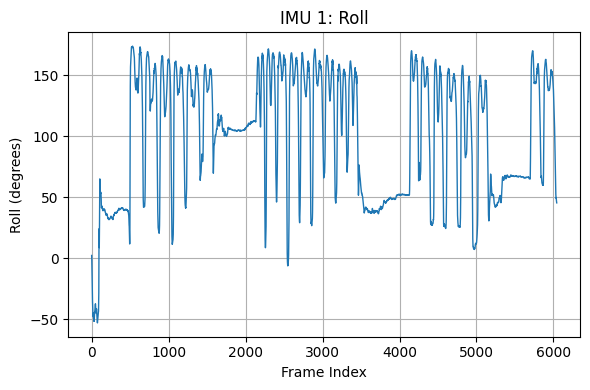

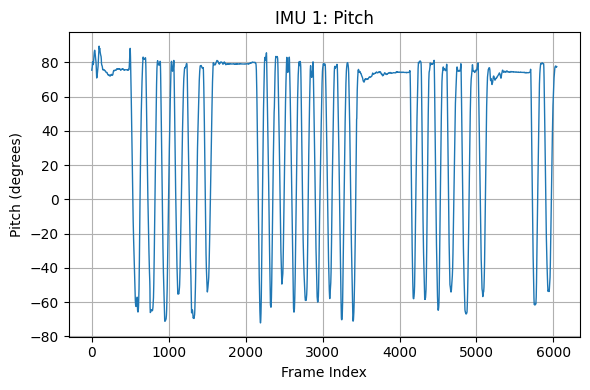

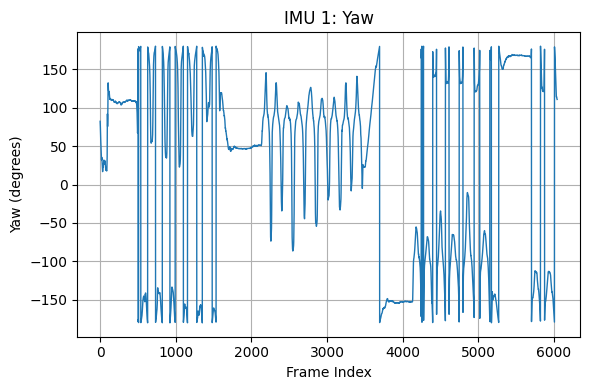

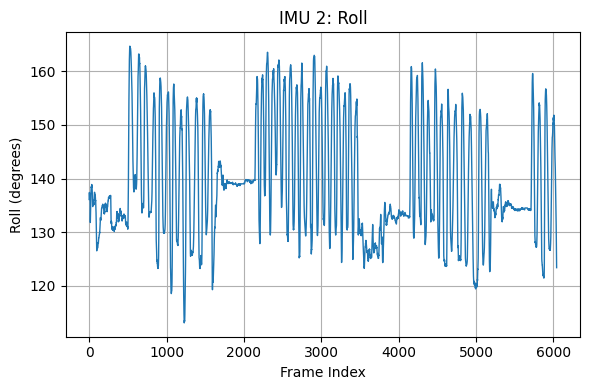

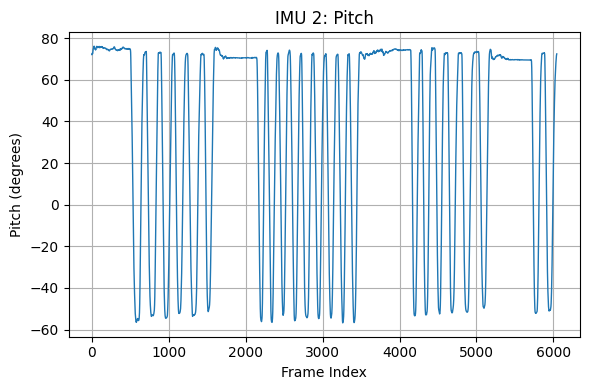

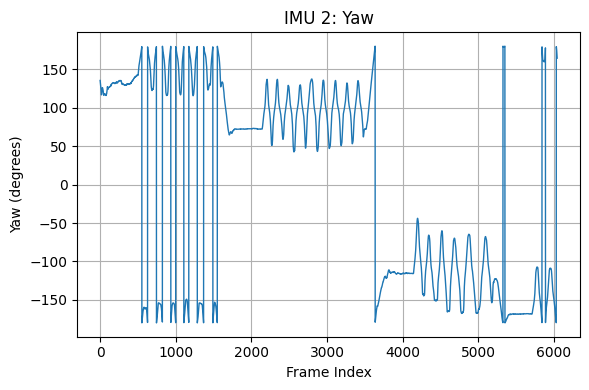

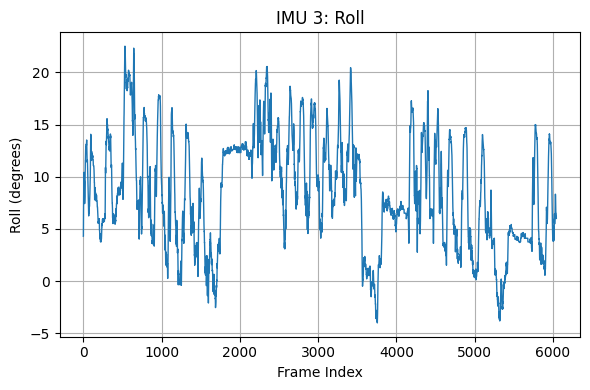

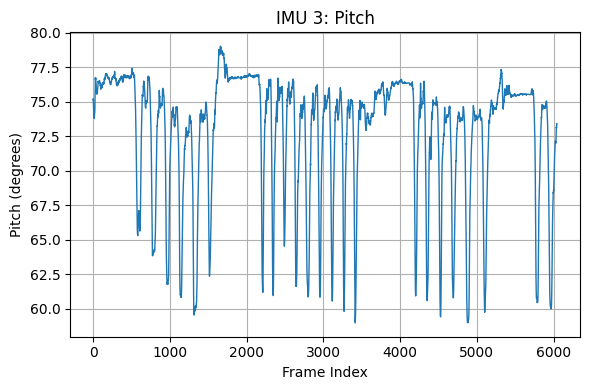

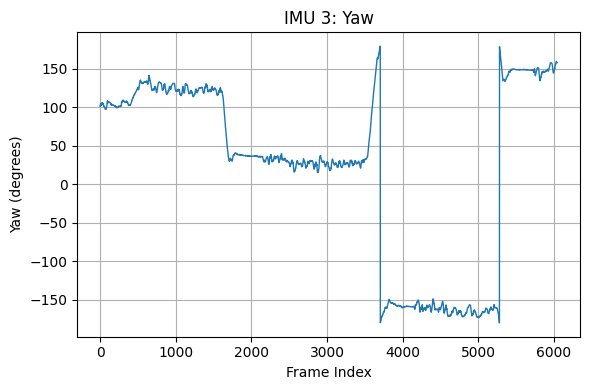

In [ ]:


# ----------------------------------------------------------------------
# Assumptions:
# - `processed_data` is a dict with keys "IMU-1", "IMU-2", "IMU-3"
#   where each value is a pandas DataFrame containing quaternion columns
#   ["q1", "q2", "q3", "q0"] for each frame.
# - `num_frames` is the total number of frames in each IMU DataFrame.
# ----------------------------------------------------------------------

# Initialize lists to hold [frame, roll, pitch, yaw] for each IMU
imu1_data_records = []
imu2_data_records = []
imu3_data_records = []

# Loop over all frames; extract quaternion, convert to Euler, and record
for frame in range(num_frames):
    # Extract quaternion for each IMU (in [x, y, z, w] order)
    q_1 = processed_data["IMU-1"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_2 = processed_data["IMU-2"].iloc[frame][["q1", "q2", "q3", "q0"]].values
    q_3 = processed_data["IMU-3"].iloc[frame][["q1", "q2", "q3", "q0"]].values

    # Convert each quaternion to a Rotation object
    R_1 = R.from_quat(q_1)
    R_2 = R.from_quat(q_2)
    R_3 = R.from_quat(q_3)

    # Convert to Euler angles (roll, pitch, yaw) in degrees, using 'xyz' convention
    roll_1, pitch_1, yaw_1 = R_1.as_euler('xyz', degrees=True)
    roll_2, pitch_2, yaw_2 = R_2.as_euler('xyz', degrees=True)
    roll_3, pitch_3, yaw_3 = R_3.as_euler('xyz', degrees=True)

    # Append [frame, roll, pitch, yaw] to the respective lists
    imu1_data_records.append([frame, roll_1, pitch_1, yaw_1])
    imu2_data_records.append([frame, roll_2, pitch_2, yaw_2])
    imu3_data_records.append([frame, roll_3, pitch_3, yaw_3])

# Convert each IMU’s records into a NumPy array of shape (num_frames, 4)
imu1_arr = np.array(imu1_data_records)  # columns: [frame, roll, pitch, yaw]
imu2_arr = np.array(imu2_data_records)
imu3_arr = np.array(imu3_data_records)

# Extract time (frame index) and each Euler angle series
t1 = imu1_arr[:, 0]
roll1, pitch1, yaw1 = imu1_arr[:, 1], imu1_arr[:, 2], imu1_arr[:, 3]

t2 = imu2_arr[:, 0]
roll2, pitch2, yaw2 = imu2_arr[:, 1], imu2_arr[:, 2], imu2_arr[:, 3]

t3 = imu3_arr[:, 0]
roll3, pitch3, yaw3 = imu3_arr[:, 1], imu3_arr[:, 2], imu3_arr[:, 3]

# ----------------------------------------------------------------------
# Plotting: 9 separate figures for each IMU’s Roll, Pitch, and Yaw
# ----------------------------------------------------------------------

# IMU 1 - Roll
plt.figure(figsize=(6, 4))
plt.plot(t1, roll1, linewidth=1)
plt.title('IMU 1: Roll')
plt.xlabel('Frame Index')
plt.ylabel('Roll (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 1 - Pitch
plt.figure(figsize=(6, 4))
plt.plot(t1, pitch1, linewidth=1)
plt.title('IMU 1: Pitch')
plt.xlabel('Frame Index')
plt.ylabel('Pitch (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 1 - Yaw
plt.figure(figsize=(6, 4))
plt.plot(t1, yaw1, linewidth=1)
plt.title('IMU 1: Yaw')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 2 - Roll
plt.figure(figsize=(6, 4))
plt.plot(t2, roll2, linewidth=1)
plt.title('IMU 2: Roll')
plt.xlabel('Frame Index')
plt.ylabel('Roll (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 2 - Pitch
plt.figure(figsize=(6, 4))
plt.plot(t2, pitch2, linewidth=1)
plt.title('IMU 2: Pitch')
plt.xlabel('Frame Index')
plt.ylabel('Pitch (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 2 - Yaw
plt.figure(figsize=(6, 4))
plt.plot(t2, yaw2, linewidth=1)
plt.title('IMU 2: Yaw')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 3 - Roll
plt.figure(figsize=(6, 4))
plt.plot(t3, roll3, linewidth=1)
plt.title('IMU 3: Roll')
plt.xlabel('Frame Index')
plt.ylabel('Roll (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 3 - Pitch
plt.figure(figsize=(6, 4))
plt.plot(t3, pitch3, linewidth=1)
plt.title('IMU 3: Pitch')
plt.xlabel('Frame Index')
plt.ylabel('Pitch (degrees)')
plt.grid(True)
plt.tight_layout()

# IMU 3 - Yaw
plt.figure(figsize=(6, 4))
plt.plot(t3, yaw3, linewidth=1)
plt.title('IMU 3: Yaw')
plt.xlabel('Frame Index')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.tight_layout()

# Render all plots
plt.show()


# Load the data for 6 IMU config


In [43]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

# --- Configuration / Constants --- #
imu_ids = ['IMU-6', 'IMU-5', 'IMU-4', 'IMU-3', 'IMU-2', 'IMU-1']
ROOT_ID = 'ROOT'
USER_HEIGHT = 1.62  # only define once

lengths = {
    'IMU-6': 0.08 * USER_HEIGHT,
    'IMU-5': 0.14 * USER_HEIGHT,
    'IMU-4': 0.09 * USER_HEIGHT,
    'IMU-3': 0.186 * USER_HEIGHT,
    'IMU-2': 0.145 * USER_HEIGHT,
    'IMU-1': 0.11 * USER_HEIGHT,
}

imu_hierarchy = {
    'IMU-6': (ROOT_ID, lengths['IMU-6']),
    'IMU-5': ('IMU-6', lengths['IMU-5']),
    'IMU-4': ('IMU-5', lengths['IMU-4']),
    'IMU-3': ('IMU-4', lengths['IMU-3']),
    'IMU-2': ('IMU-3', lengths['IMU-2']),
    'IMU-1': ('IMU-2', lengths['IMU-1']),
}

unit_vectors = {
    "IMU-6": np.array([-1, 0, 0]),
    "IMU-5": np.array([-1, 0, 0]),
    "IMU-4": np.array([-0.5, 0.7, 0.5]),
    "IMU-3": np.array([1, 0, 0]),
    "IMU-2": np.array([1, 0, 0]),
    "IMU-1": np.array([1, 0, 0]),
}

folder_name = "deniz_shoulder_flex_ext"
folder_path = os.path.join("./DataLogger", folder_name)

angles = ["Back", "Shoulder_Flex_Ext", "Shoulder_Add_Abd", "Shoulder_Rotation", "Elbow_Flex_Ext", "Hand_ROM"]
ANGLE_TO_DISPLAY = angles[2]

# Global Variables
N_FIRST_REF_FRAMES = 150
fps = 60

# --- Load all CSV files under folder_path --- #
files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
imu_data = {}

for file in files:
    parts = file.split("_")
    imu_id = parts[0]
    if "quaternion" not in file:
        continue

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Ensure there is a 'timestamp' column
    if "timestamp" not in df.columns:
        if "Time" in df.columns:
            df.rename(columns={"Time": "timestamp"}, inplace=True)
        else:
            continue

    imu_data.setdefault(imu_id, {})["quaternion_log"] = df.sort_values("timestamp")

# Keep only those IMUs that have valid quaternion logs
processed_data = {
    imu: data["quaternion_log"]
    for imu, data in imu_data.items()
    if "quaternion_log" in data
}

# If any imu_ids are missing from processed_data, drop them
available_imus = [imu for imu in imu_ids if imu in processed_data]
if len(available_imus) < len(imu_ids):
    missing = set(imu_ids) - set(available_imus)
    print(f"Warning: missing data for {missing}; they will be skipped.")

# Determine how many frames we can process (minimum over all available IMUs)
num_frames = min(len(processed_data[imu]) for imu in available_imus)

# --- Calibration (compute R_B0_to_S0 for each available IMU) --- #
R_B0_to_S0 = {}

for imu in available_imus:
    # Take the mean of the first 2 seconds of quaternions as reference
    ref_quat_df = processed_data[imu].iloc[: fps * 2][['q0', 'q1', 'q2', 'q3']]
    q_sensor = ref_quat_df.mean().values  # [q0_mean, q1_mean, q2_mean, q3_mean]
    # scipy expects [x, y, z, w], so we reorder as [q1, q2, q3, q0]:
    R_S0_Gp = R.from_quat([q_sensor[1], q_sensor[2], q_sensor[3], q_sensor[0]])

    bone_vec = unit_vectors[imu]
    z_axis = np.array([0.0, 0.0, 1.0])
    rot_axis = np.cross(z_axis, bone_vec)

    if np.linalg.norm(rot_axis) < 1e-6:
        R_B0_Gp = R.identity()
    else:
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(z_axis, bone_vec), -1.0, 1.0))
        R_B0_Gp = R.from_rotvec(rot_axis * angle)

    # R_B0_to_S0 = R_S0_Gp⁻¹ * R_B0_Gp
    R_B0_to_S0[imu] = R_S0_Gp.inv() * R_B0_Gp

# --- Forward Kinematics (compute segment positions for each frame) --- #
positions = []

for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.zeros(3)}
    R_Bt_Gp_dict = {}

    for imu in available_imus:
        parent, dist = imu_hierarchy[imu]

        # Read the quaternion at this frame, reorder to [x, y, z, w]
        row = processed_data[imu].iloc[frame]
        q = [row['q1'], row['q2'], row['q3'], row['q0']]
        R_St_Gp = R.from_quat(q)

        # Apply the calibration offset
        R_Bt_Gp = R_St_Gp * R_B0_to_S0[imu]
        R_Bt_Gp_dict[imu] = R_Bt_Gp

        # Compute world‐space offset vector for this IMU’s segment
        world_vec = R_Bt_Gp.apply(unit_vectors[imu] * dist)
        seg_pos[imu] = seg_pos[parent] + world_vec

    positions.append((seg_pos, R_Bt_Gp_dict))


# looking at Pure Angles wrt IMU Globals


Calibration for IMU-6: bone vector = [-1  0  0], z-axis = [0. 0. 1.], rot_axis = [ 0. -1.  0.]
Calibration for IMU-6: angle = 1.5707963267948966
Calibration for IMU-5: bone vector = [-1  0  0], z-axis = [0. 0. 1.], rot_axis = [ 0. -1.  0.]
Calibration for IMU-5: angle = 1.5707963267948966
Calibration for IMU-4: bone vector = [-0.5  0.7  0.5], z-axis = [0. 0. 1.], rot_axis = [-0.7 -0.5  0. ]
Calibration for IMU-4: angle = 1.0471975511965979
Calibration for IMU-3: bone vector = [1 0 0], z-axis = [0. 0. 1.], rot_axis = [0. 1. 0.]
Calibration for IMU-3: angle = 1.5707963267948966
Calibration for IMU-2: bone vector = [1 0 0], z-axis = [0. 0. 1.], rot_axis = [0. 1. 0.]
Calibration for IMU-2: angle = 1.5707963267948966
Calibration for IMU-1: bone vector = [1 0 0], z-axis = [0. 0. 1.], rot_axis = [0. 1. 0.]
Calibration for IMU-1: angle = 1.5707963267948966


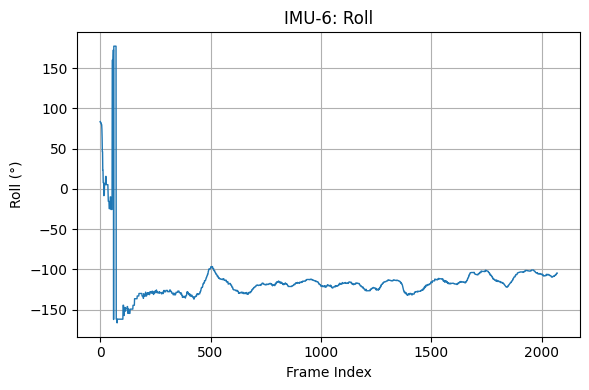

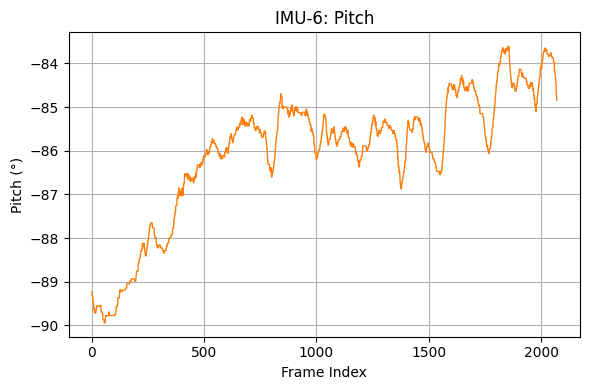

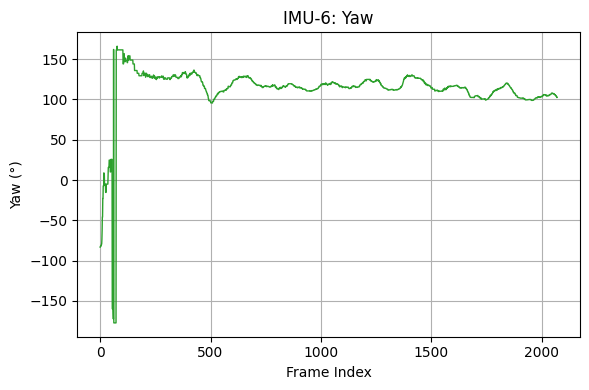

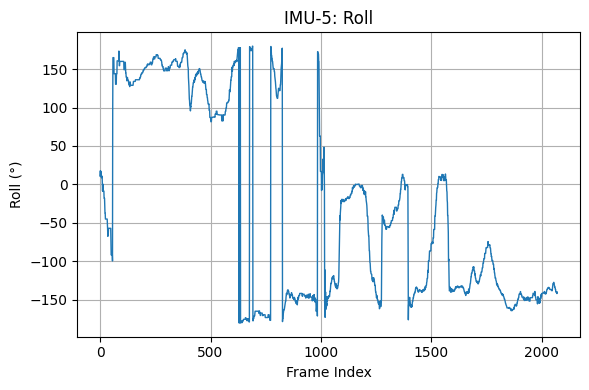

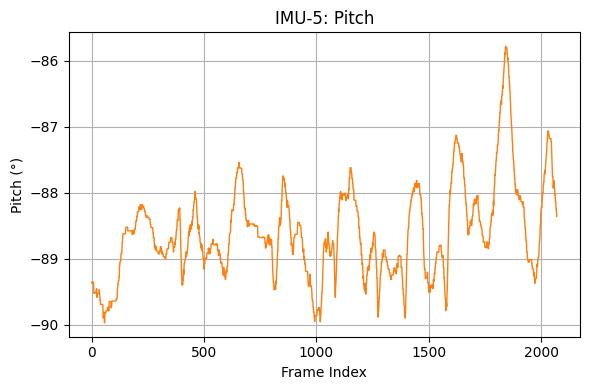

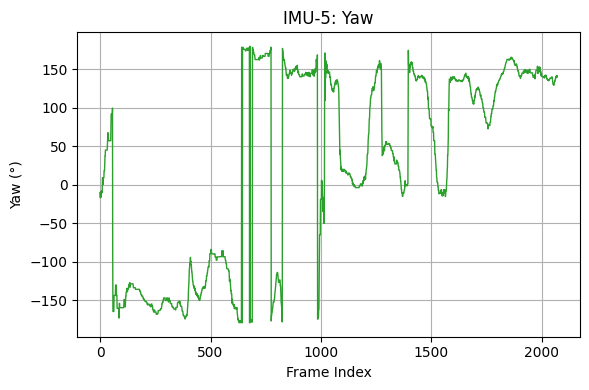

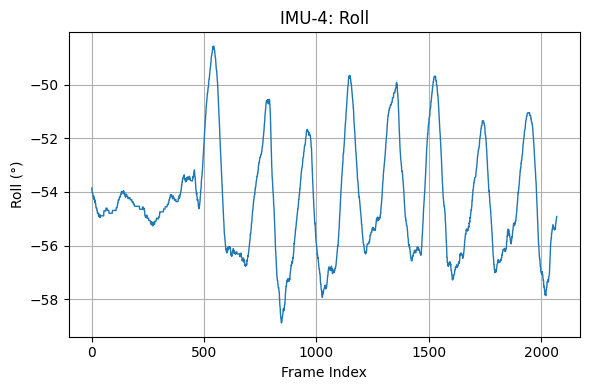

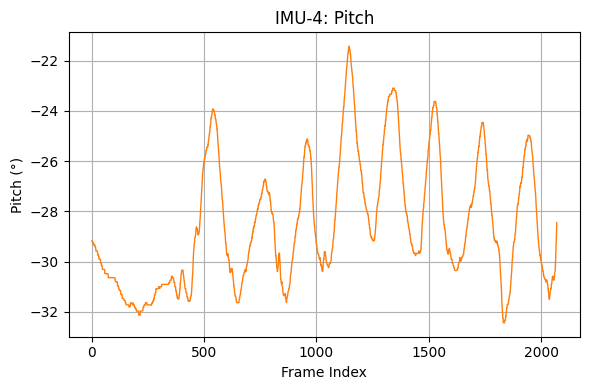

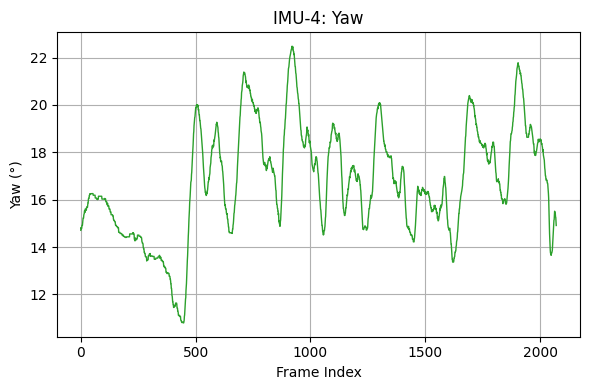

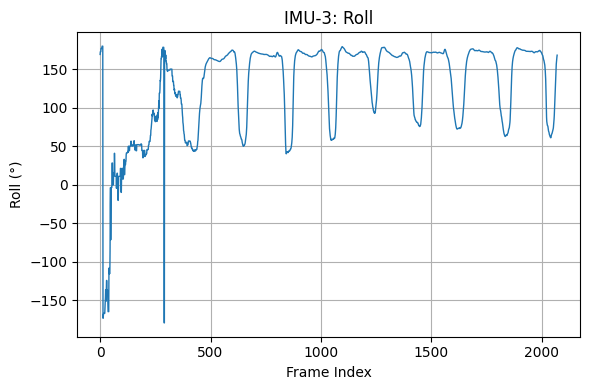

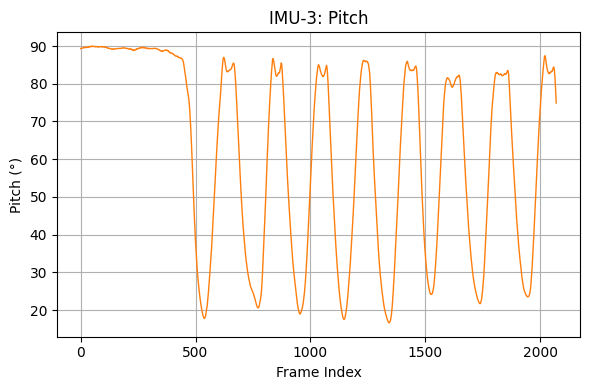

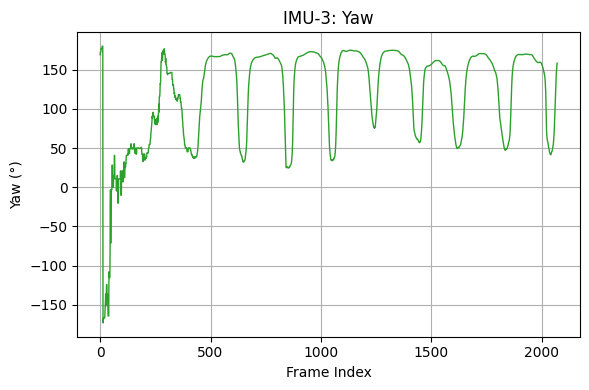

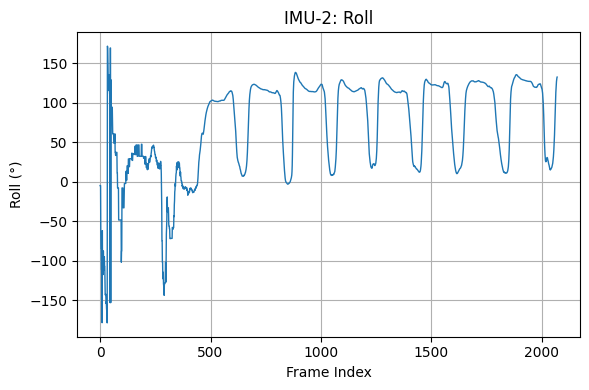

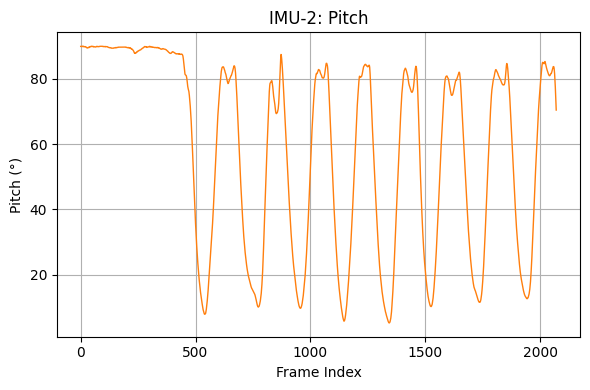

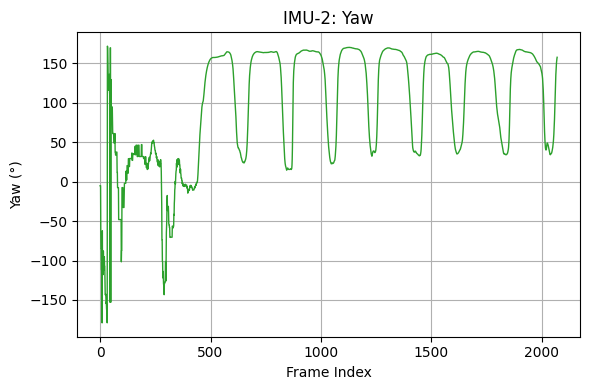

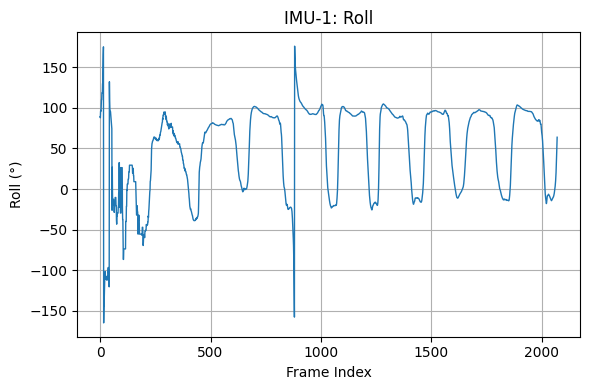

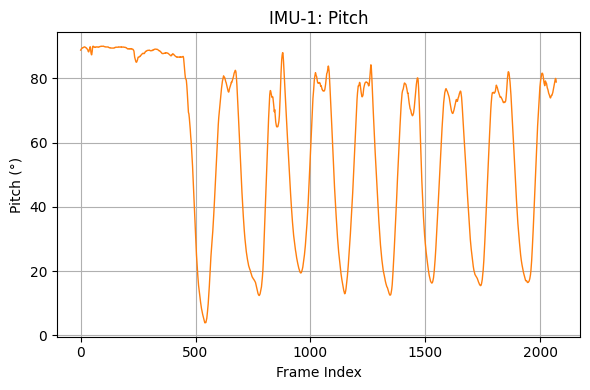

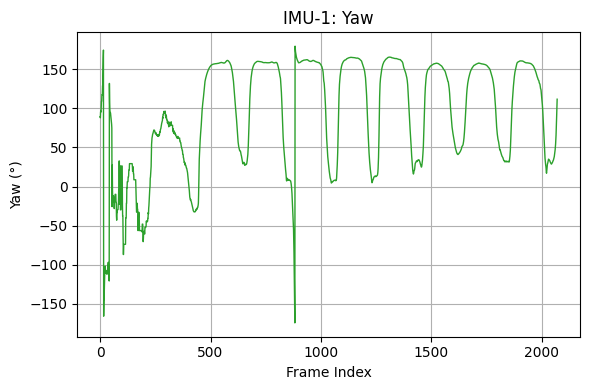

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# (Assume imu_ids, ROOT_ID, imu_hierarchy, unit_vectors,
#  processed_data, R_B0_to_S0, num_frames, etc. are already defined)
# --- Configuration / Constants --- #


# --- Calibration (compute R_B0_to_S0 for each available IMU) --- #
R_B0_to_S0 = {}
for imu in available_imus:
    # Take the mean of the first 2 seconds of quaternions as reference
    ref_quat_df = processed_data[imu].iloc[: fps * 2][['q0', 'q1', 'q2', 'q3']]
    q_sensor = ref_quat_df.mean().values  # [q0_mean, q1_mean, q2_mean, q3_mean]
    # scipy expects [x, y, z, w], so we reorder as [q1, q2, q3, q0]:
    R_S0_Gp = R.from_quat([q_sensor[1], q_sensor[2], q_sensor[3], q_sensor[0]])

    bone_vec = unit_vectors[imu]
    z_axis = np.array([0.0, 0.0, 1.0])
    rot_axis = np.cross(z_axis, bone_vec)
    print(f"Calibration for {imu}: bone vector = {bone_vec}, z-axis = {z_axis}, rot_axis = {rot_axis}")
    if np.linalg.norm(rot_axis) < 1e-6:
        R_B0_Gp = R.identity()
    else:
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(z_axis, bone_vec), -1.0, 1.0))
        R_B0_Gp = R.from_rotvec(rot_axis * angle)
    print(f"Calibration for {imu}: angle = {angle}" )
    # R_B0_to_S0 = R_S0_Gp⁻¹ * R_B0_Gp
    R_B0_to_S0[imu] = R_S0_Gp.inv() * R_B0_Gp


# --- 2) FORWARD KINEMATICS and RECORDING EULER ANGLES --- #
# Create a structure to hold roll, pitch, yaw for each IMU across frames
imu_euler = {
    imu: {"roll": [], "pitch": [], "yaw": []}
    for imu in imu_ids
}

positions = []  # (optional) if you still want segment positions
for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.zeros(3)}
    R_Bt_Gp_dict = {}

    for imu in imu_ids:
        parent, dist = imu_hierarchy[imu]

        # Extract current quaternion [q0, q1, q2, q3]
        q_row = processed_data[imu].iloc[frame][['q0', 'q1', 'q2', 'q3']].values
        # Convert to Rotation object (scipy expects [x, y, z, w])
        R_St_Gp = R.from_quat([q_row[1], q_row[2], q_row[3], q_row[0]])

        # Combine with calibration to get bone-to-global orientation
        R_Bt_Gp = R_St_Gp * R_B0_to_S0[imu]
        R_Bt_Gp_dict[imu] = R_Bt_Gp

        # Record Euler angles (roll, pitch, yaw) in degrees using 'xyz' convention
        roll, pitch, yaw = R_Bt_Gp.as_euler('xyz', degrees=True)
        imu_euler[imu]["roll"].append(roll)
        imu_euler[imu]["pitch"].append(pitch)
        imu_euler[imu]["yaw"].append(yaw)

        # (Optional) Compute and store segment endpoint positions
        world_vec = R_Bt_Gp.apply(unit_vectors[imu] * dist)
        seg_pos[imu] = seg_pos[parent] + world_vec

    positions.append((seg_pos, R_Bt_Gp_dict))

# Convert the recorded Euler lists into NumPy arrays for plotting
for imu in imu_ids:
    imu_euler[imu]["roll"]  = np.array(imu_euler[imu]["roll"])
    imu_euler[imu]["pitch"] = np.array(imu_euler[imu]["pitch"])
    imu_euler[imu]["yaw"]   = np.array(imu_euler[imu]["yaw"])

# Create a common time axis (frame indices)
time = np.arange(num_frames)

# --- 3) PLOTTING: Three Separate Figures per IMU (Roll, Pitch, Yaw) --- #
# Color mapping: roll → blue, pitch → orange, yaw → green
color_map = {"roll": "tab:blue", "pitch": "tab:orange", "yaw": "tab:green"}

for imu in imu_ids:
    for angle_name in ["roll", "pitch", "yaw"]:
        plt.figure(figsize=(6, 4))
        plt.plot(time, imu_euler[imu][angle_name],
                 color=color_map[angle_name], linewidth=1)
        plt.title(f"{imu}: {angle_name.capitalize()}")
        plt.xlabel("Frame Index")
        plt.ylabel(f"{angle_name.capitalize()} (°)")
        plt.grid(True)
        plt.tight_layout()

# Finally, display all figures
plt.show()


# Data wrt IMU 6 without any Calibration


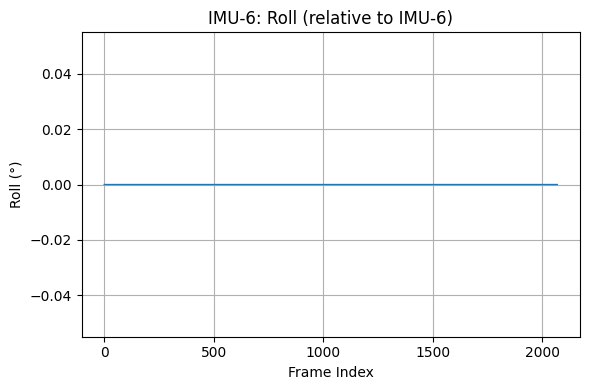

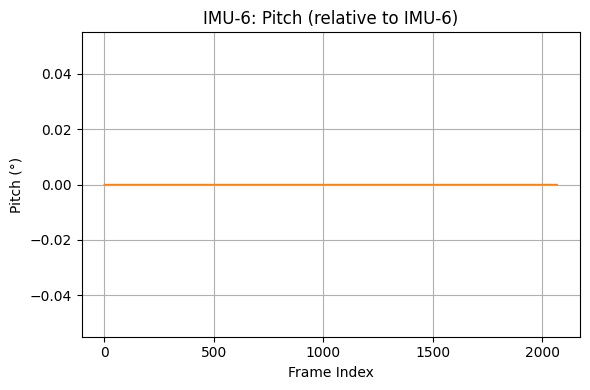

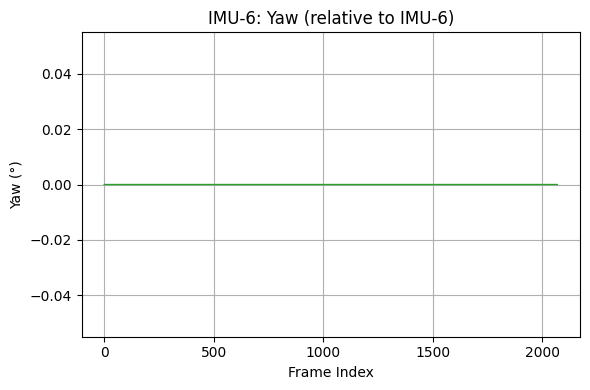

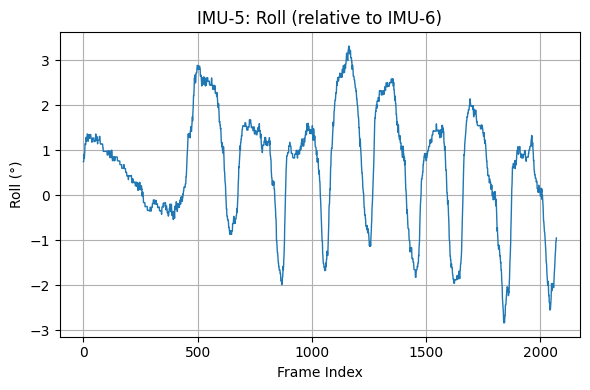

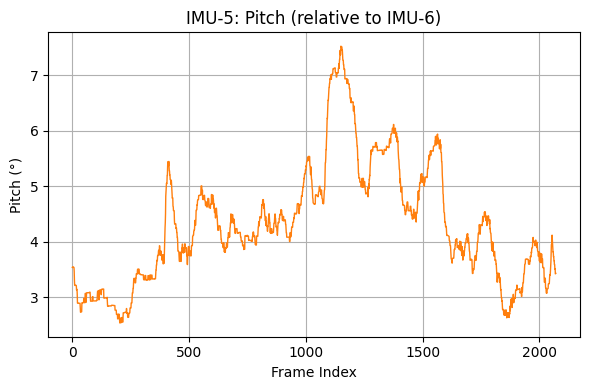

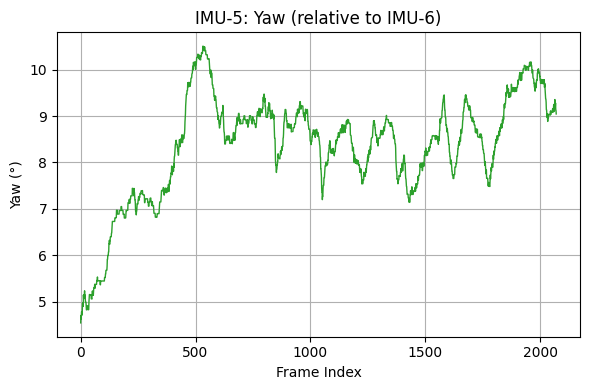

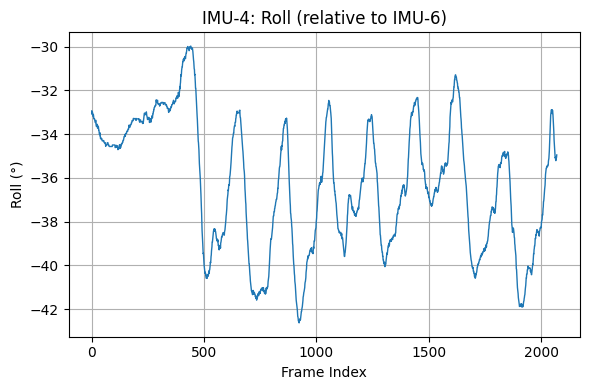

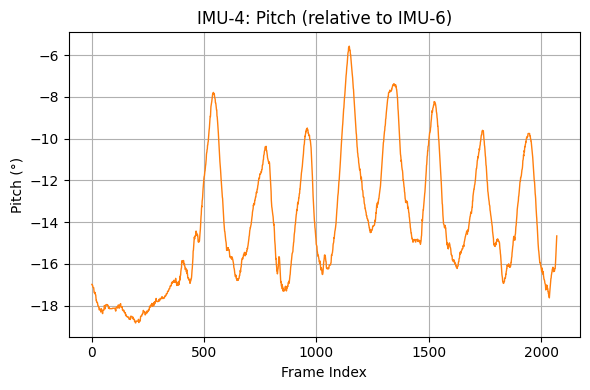

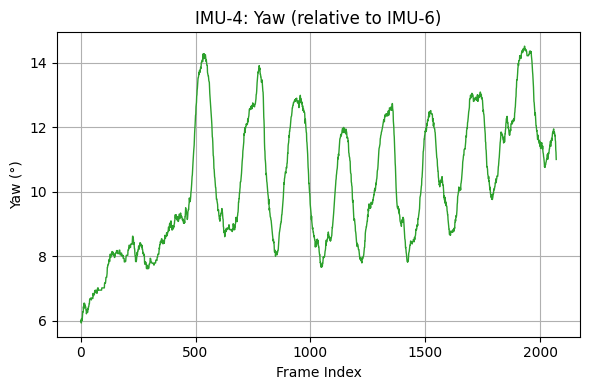

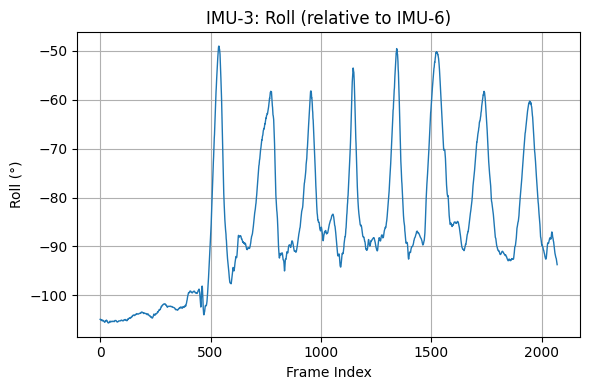

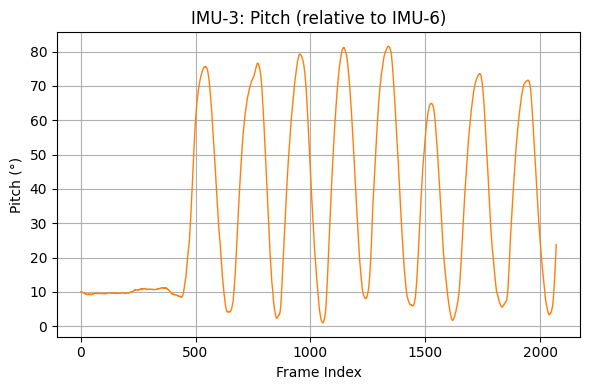

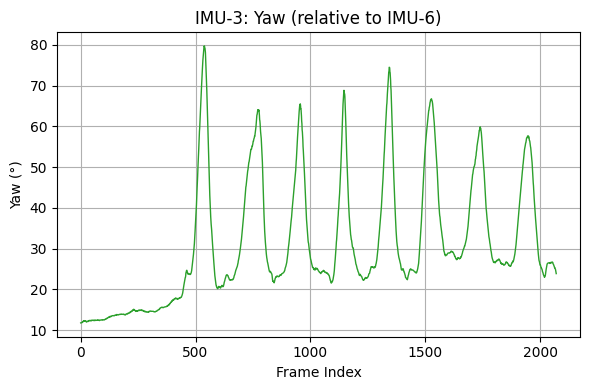

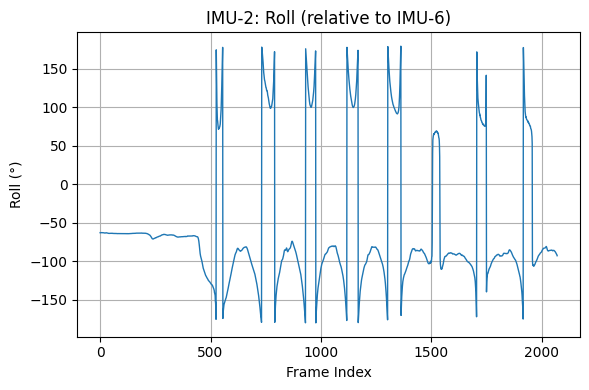

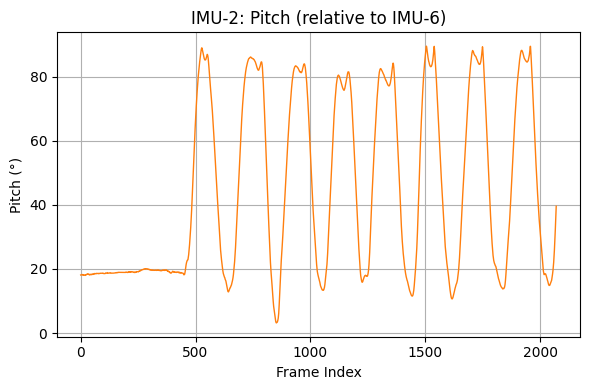

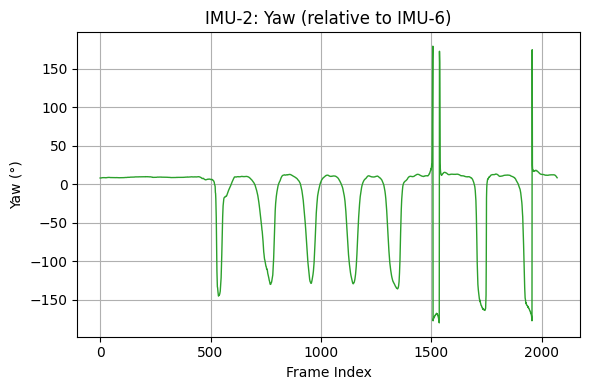

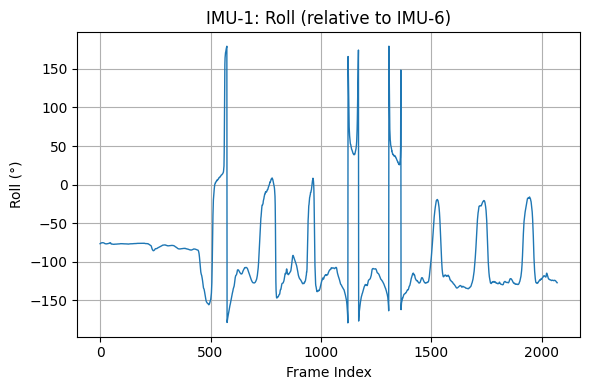

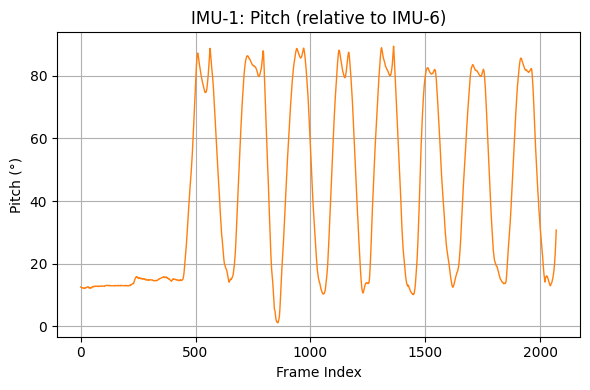

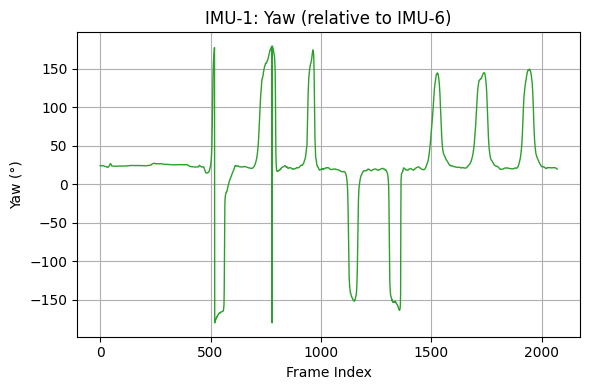

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ─── Assumptions ───────────────────────────────────────────────────────────────
# • `processed_data` is a dict with keys "IMU-1" … "IMU-6", each a DataFrame containing
#   quaternion columns ["q0","q1","q2","q3"] per frame.
# • `num_frames` is the integer number of frames to process (same length for all).
# • We want IMU-6 as the reference: every other IMU’s orientation will be R_ref⁻¹ * R_imu.
# ────────────────────────────────────────────────────────────────────────────────

imu_ids = ['IMU-6','IMU-5','IMU-4','IMU-3','IMU-2','IMU-1']

# 1) Prepare a dict to hold [frame, roll, pitch, yaw] for each IMU
euler_records = { imu: [] for imu in imu_ids }

# 2) Loop over frames and compute each IMU’s orientation relative to IMU-6
for frame in range(num_frames):
    # Extract the quaternion for IMU-6 (reference), reorder to [x, y, z, w]
    q_ref_raw = processed_data["IMU-6"].iloc[frame][["q1","q2","q3","q0"]].values
    R_ref = R.from_quat(q_ref_raw)                 # R_ref maps IMU-6 body→global
    R_ref_inv = R_ref.inv()                         # its inverse

    # Now iterate through all six IMUs
    for imu in imu_ids:
        # Extract this IMU’s “raw” quaternion and build a Rotation
        q_raw = processed_data[imu].iloc[frame][["q1","q2","q3","q0"]].values
        R_imu = R.from_quat(q_raw)                  # body→global for this IMU

        # Compute “relative” rotation: root⁻¹ * this_IMU
        # → effectively expresses IMU’s pose in IMU-6’s local frame
        R_rel = R_ref_inv * R_imu

        # Convert to Euler angles (roll, pitch, yaw) in degrees, using 'xyz' order
        roll, pitch, yaw = R_rel.as_euler('xyz', degrees=True)

        # Append [frame, roll, pitch, yaw] into that IMU’s record list
        euler_records[imu].append([frame, roll, pitch, yaw])

# 3) Convert each IMU’s list into a NumPy array of shape (num_frames, 4)
for imu in imu_ids:
    euler_records[imu] = np.array(euler_records[imu])  
    # columns: 0=frame, 1=roll, 2=pitch, 3=yaw

# 4) Extract per-IMU time and angle series for plotting
time = np.arange(num_frames)  # same for all IMUs

# 5) Plotting: three separate subplots per IMU (roll, pitch, yaw)
color_map = {"roll":"tab:blue", "pitch":"tab:orange", "yaw":"tab:green"}

for imu in imu_ids:
    data = euler_records[imu]
    # data[:,1] = roll, data[:,2] = pitch, data[:,3] = yaw
    for idx, angle_name in enumerate(["roll","pitch","yaw"]):
        plt.figure(figsize=(6,4))
        plt.plot(time, data[:, idx+1], color=color_map[angle_name], linewidth=1)
        plt.title(f"{imu}: {angle_name.capitalize()} (relative to IMU-6)")
        plt.xlabel("Frame Index")
        plt.ylabel(f"{angle_name.capitalize()} (°)")
        plt.grid(True)
        plt.tight_layout()

plt.show()


# Data wrt IMU 6 without Calibration using Queternions


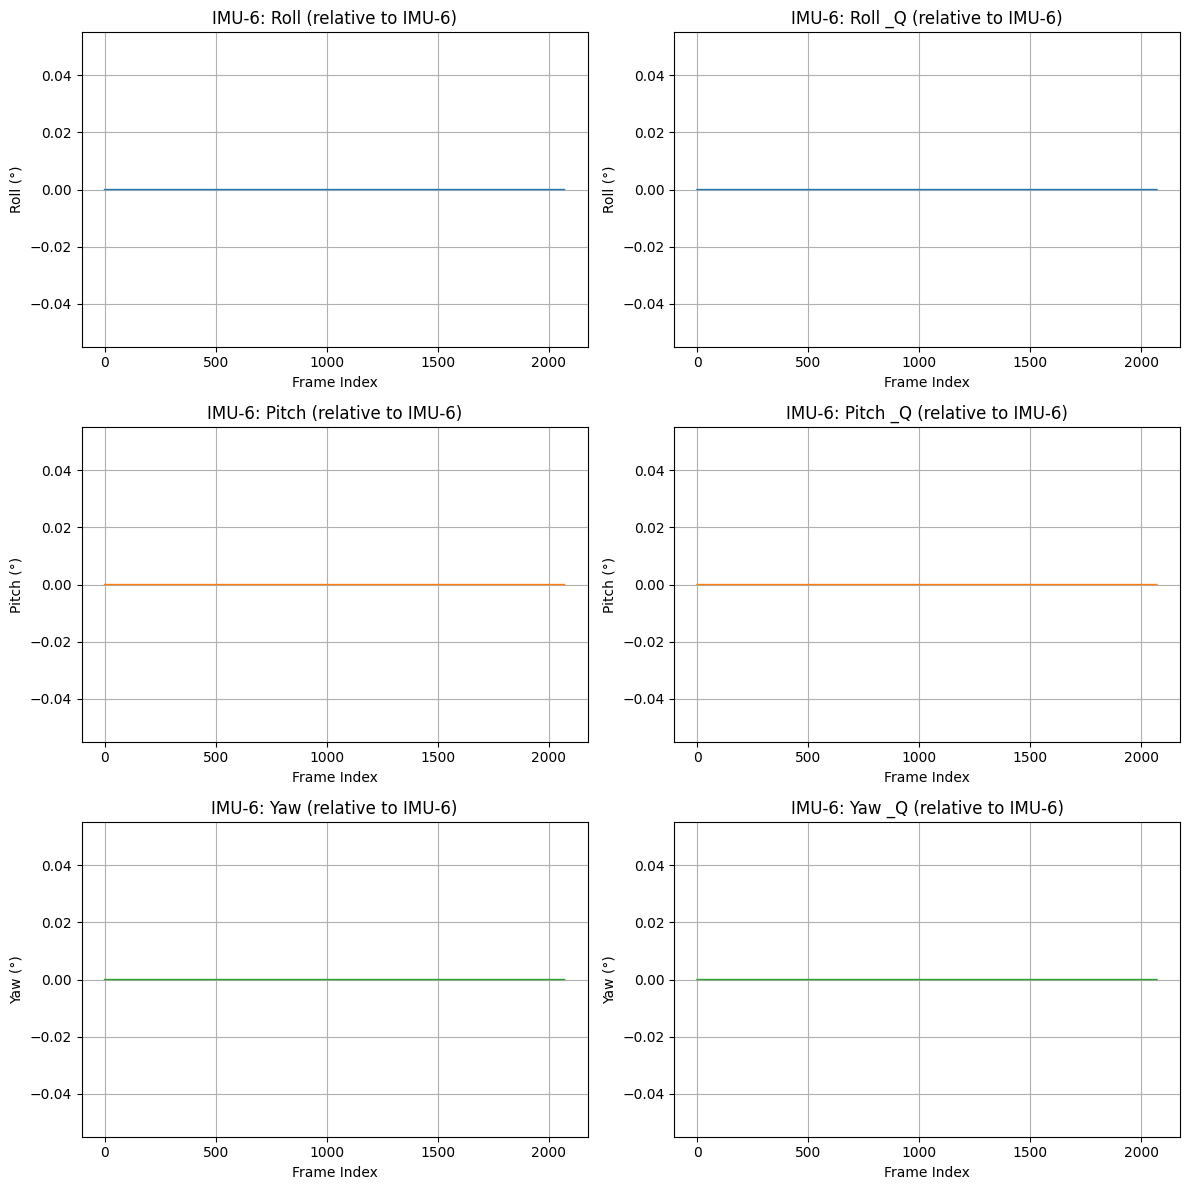

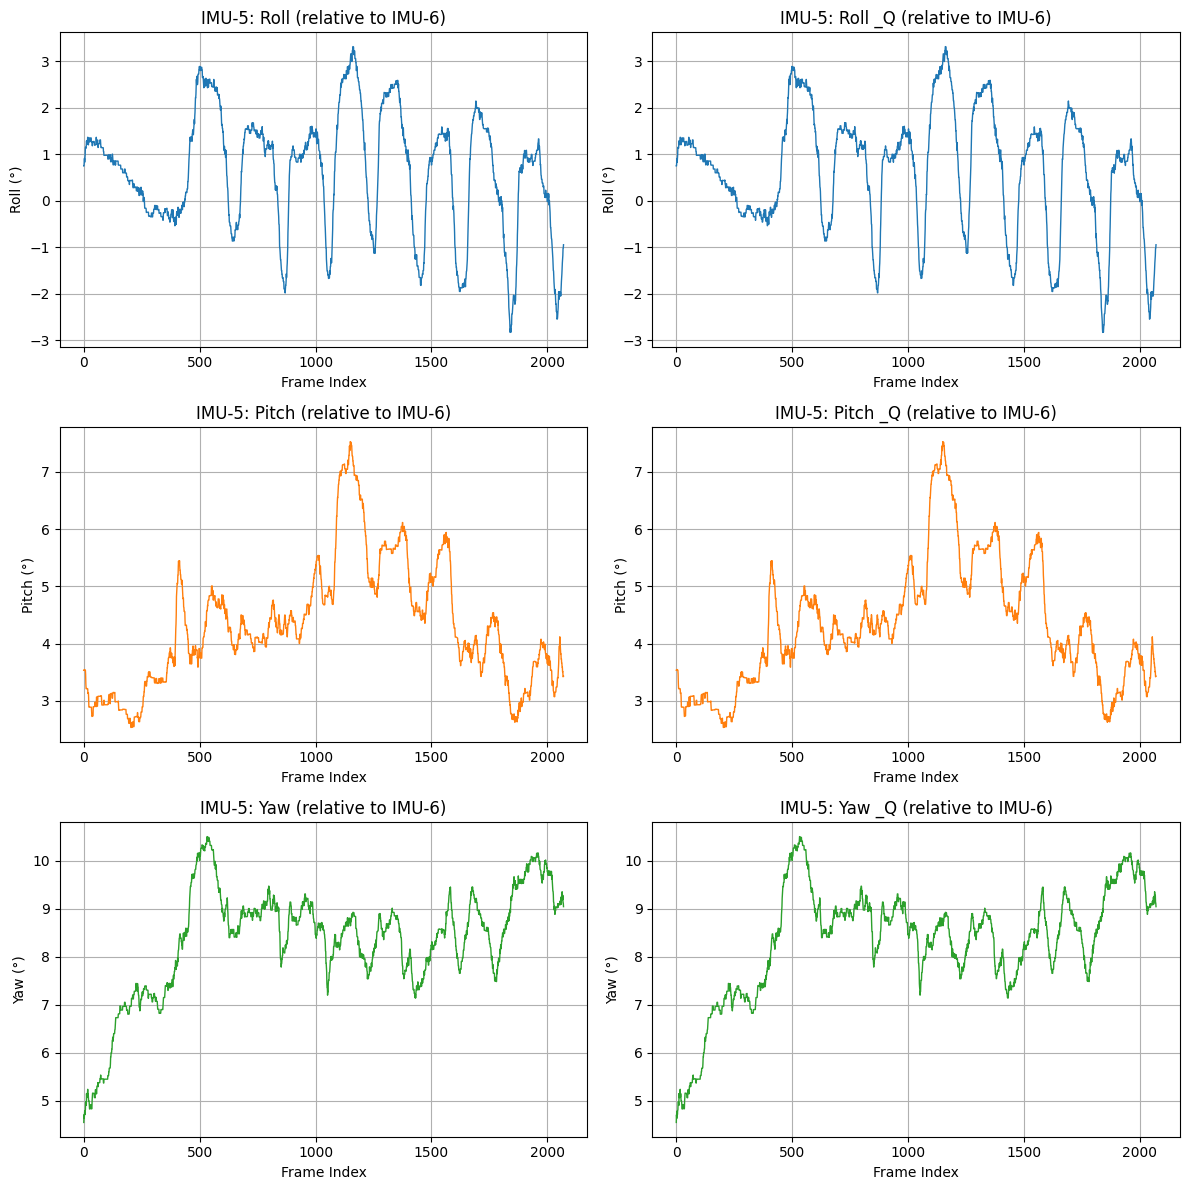

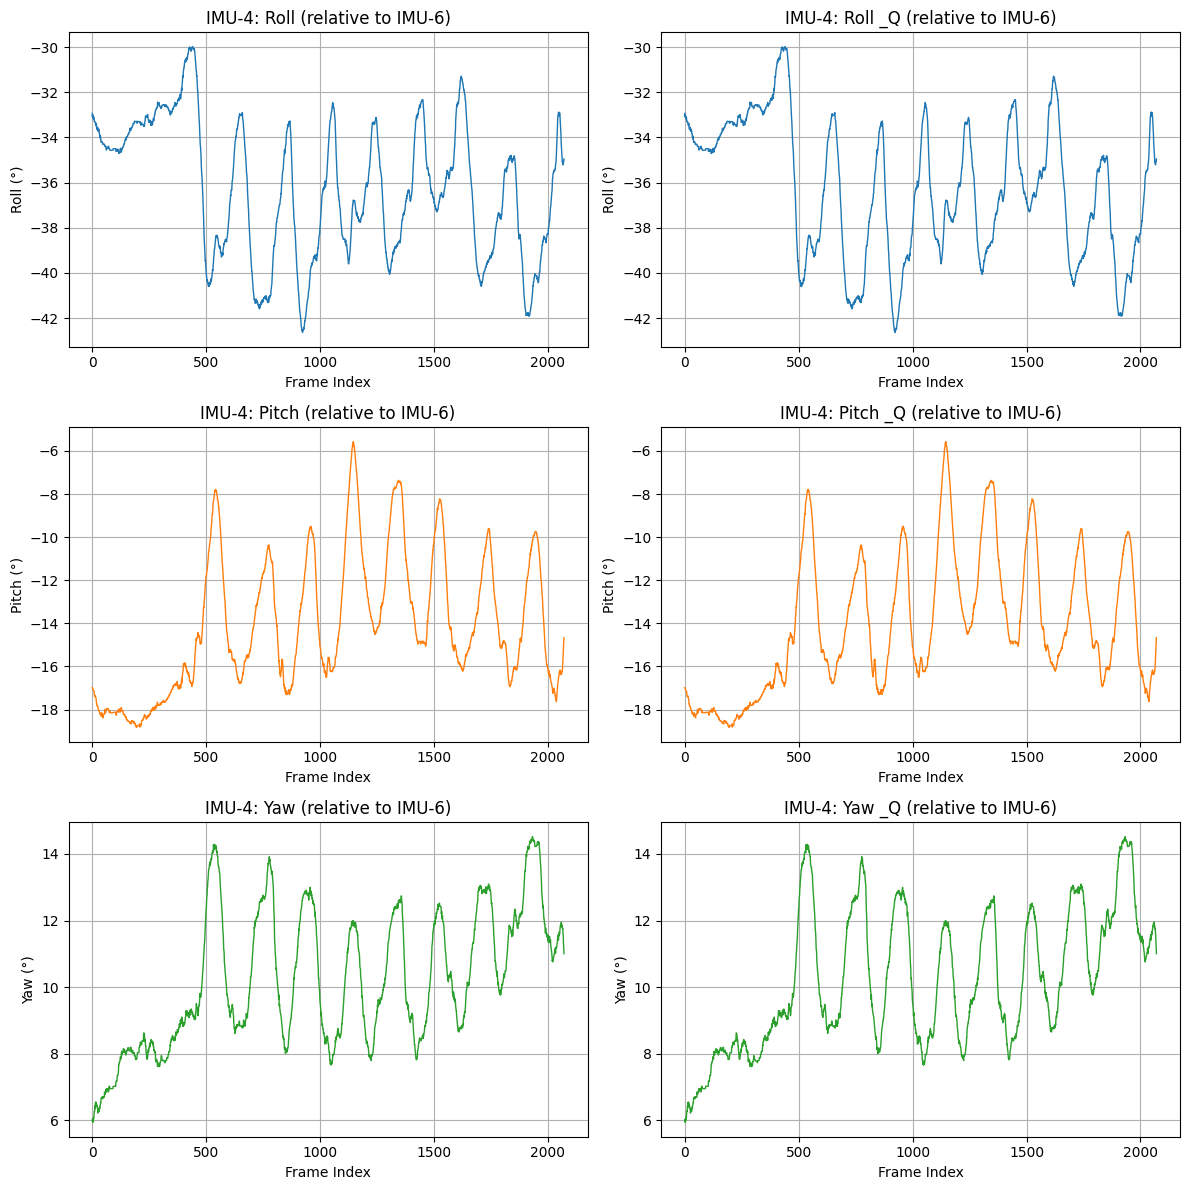

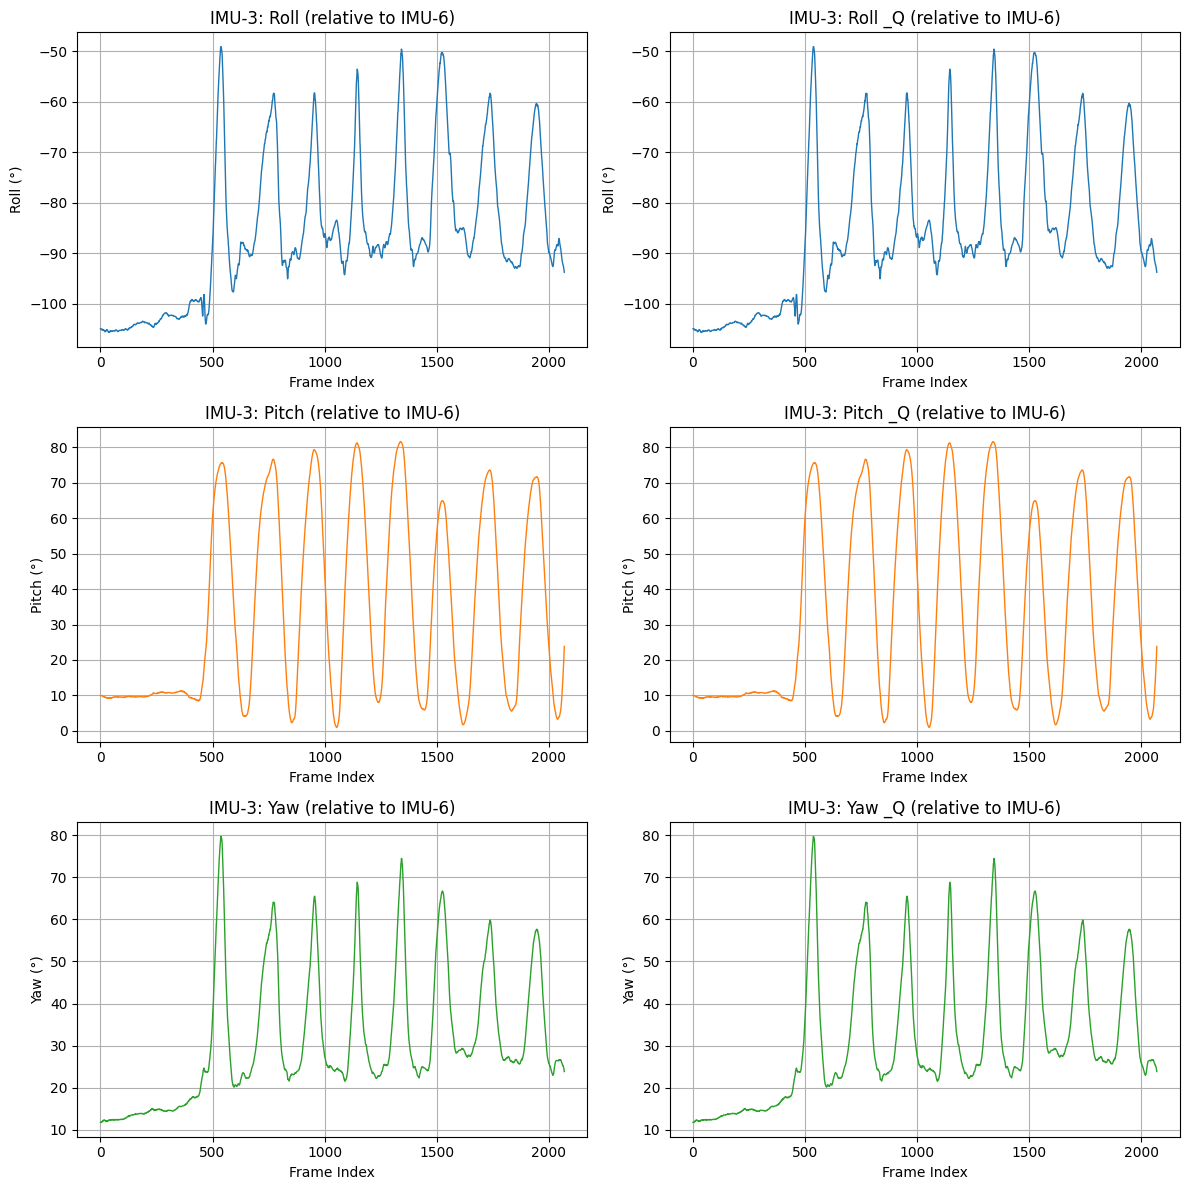

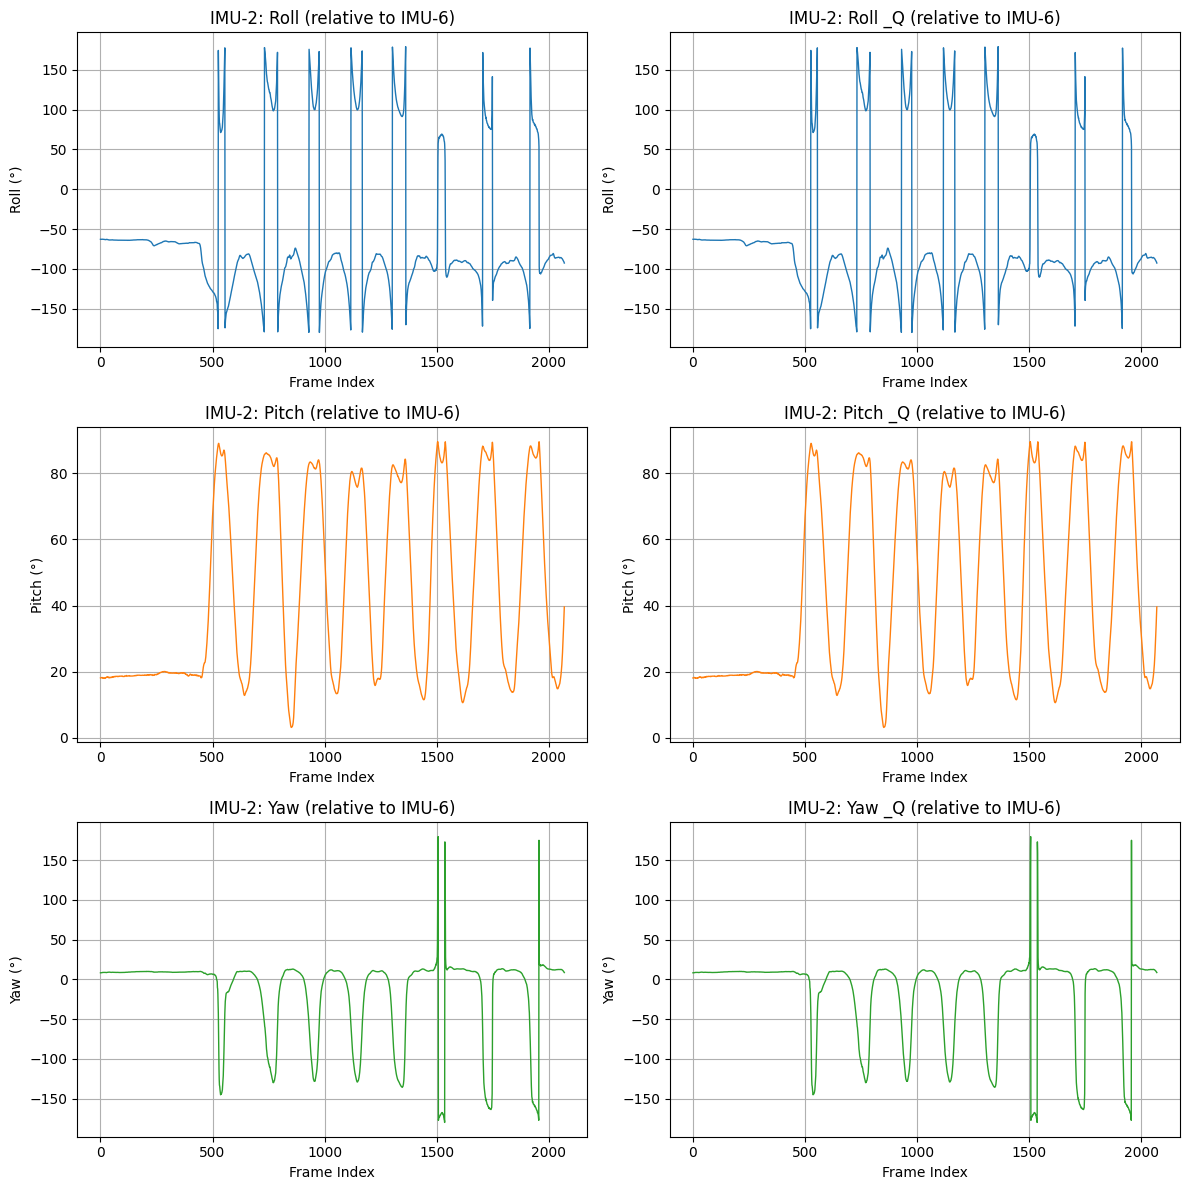

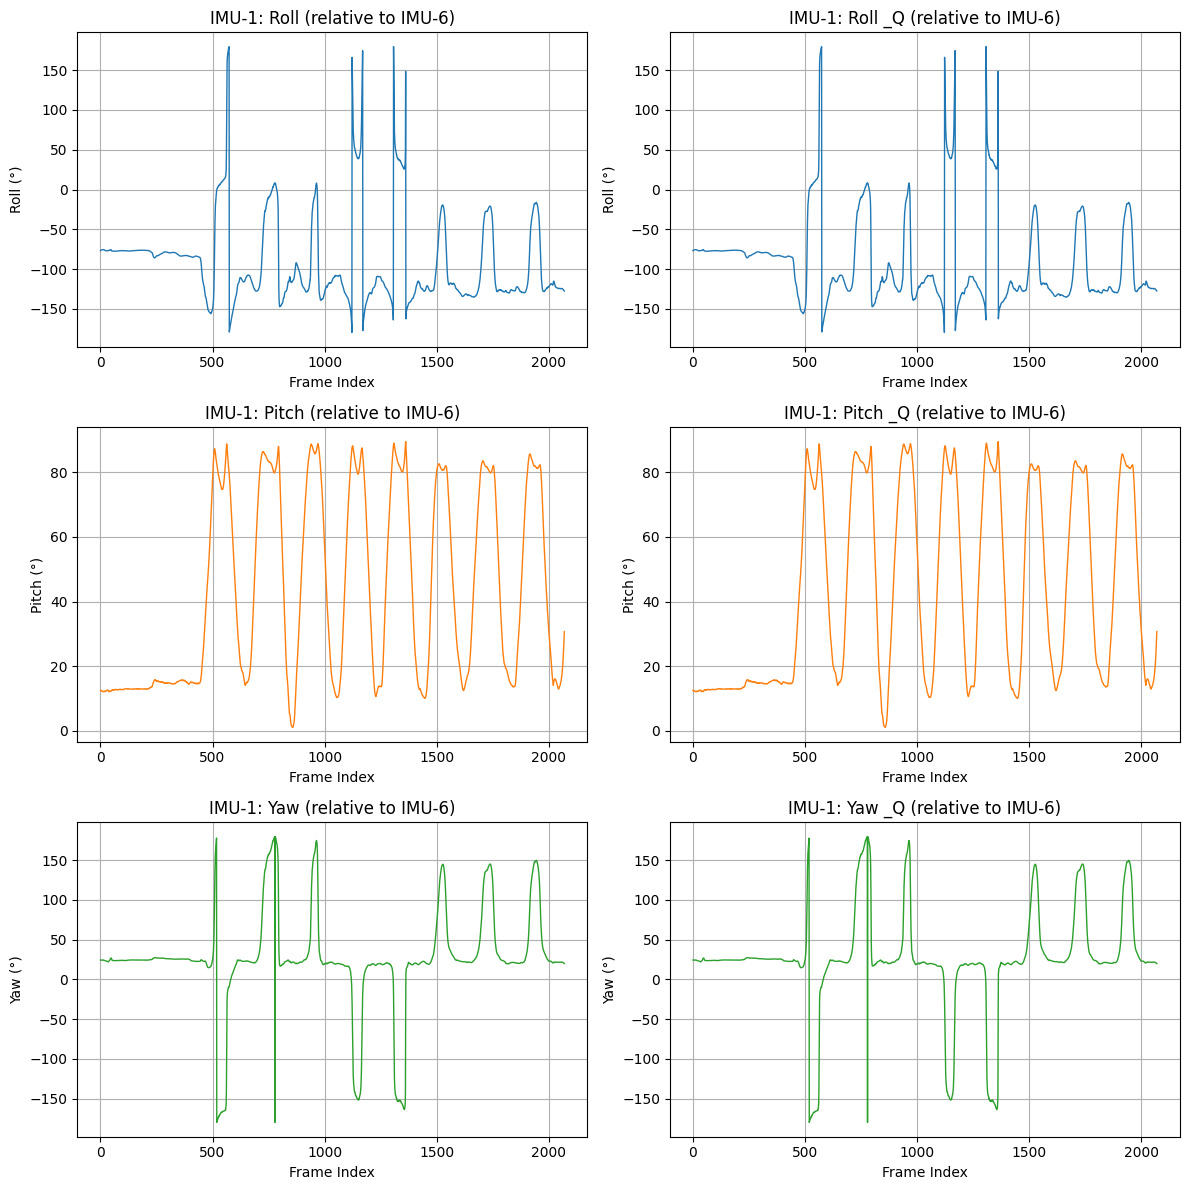

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ─── Assumptions ───────────────────────────────────────────────────────────────
# • `processed_data` is a dict with keys "IMU-1" … "IMU-6", each a DataFrame containing
#   quaternion columns ["q0","q1","q2","q3"] per frame.
# • `num_frames` is the integer number of frames to process (same length for all).
# • We want IMU-6 as the reference: every other IMU’s orientation will be R_ref⁻¹ * R_imu.
# ────────────────────────────────────────────────────────────────────────────────

imu_ids = ['IMU-6','IMU-5','IMU-4','IMU-3','IMU-2','IMU-1']

# 1) Prepare a dict to hold [frame, roll, pitch, yaw] for each IMU
euler_records = { imu: [] for imu in imu_ids }
euler_records_q = { imu: [] for imu in imu_ids }

# 2) Loop over frames and compute each IMU’s orientation relative to IMU-6
for frame in range(num_frames):
    # Extract the quaternion for IMU-6 (reference), reorder to [x, y, z, w]
    q_ref_raw = processed_data["IMU-6"].iloc[frame][["q1","q2","q3","q0"]].values
    R_ref = R.from_quat(q_ref_raw)                 # R_ref maps IMU-6 body→global
    R_ref_inv = R_ref.inv()                         # its inverse

    # Now iterate through all six IMUs
    for imu in imu_ids:
        # Extract this IMU’s “raw” quaternion and build a Rotation
        q_raw = processed_data[imu].iloc[frame][["q1","q2","q3","q0"]].values
        R_imu = R.from_quat(q_raw)                  # body→global for this IMU

        q_rel = compute_relative_quaternion(q_ref_raw, q_raw)
        R_rel2 = R.from_quat(q_rel)                  # body→global for this IMU
        # Compute “relative” rotation: root⁻¹ * this_IMU
        # → effectively expresses IMU’s pose in IMU-6’s local frame
        R_rel = R_ref_inv * R_imu

        # Convert to Euler angles (roll, pitch, yaw) in degrees, using 'xyz' order
        roll, pitch, yaw = R_rel.as_euler('xyz', degrees=True)
        
        roll_q, pitch_q, yaw_q = R_rel2.as_euler('xyz', degrees=True)

        # Append [frame, roll, pitch, yaw] into that IMU’s record list
        euler_records[imu].append([frame, roll, pitch, yaw])
        euler_records_q[imu].append([frame, roll_q, pitch_q, yaw_q])

# 3) Convert each IMU’s list into a NumPy array of shape (num_frames, 4)
for imu in imu_ids:
    euler_records[imu] = np.array(euler_records[imu])  
    # columns: 0=frame, 1=roll, 2=pitch, 3=yaw
    euler_records_q[imu] = np.array(euler_records_q[imu]) 
# 4) Extract per-IMU time and angle series for plotting
time = np.arange(num_frames)  # same for all IMUs

# 5) Plotting: three separate subplots per IMU (roll, pitch, yaw)
color_map = {"roll":"tab:blue", "pitch":"tab:orange", "yaw":"tab:green"}

angle_names = ["roll", "pitch", "yaw"]

for imu in imu_ids:
    # Grab both datasets for this IMU
    src_data = {
        "euler":    euler_records[imu],
        "euler_q":  euler_records_q[imu]
    }

    # Create a 3×2 grid: rows=angles (roll/pitch/yaw), cols=(euler, euler_q)
    fig, axes = plt.subplots(
        nrows=3,
        ncols=2,
        figsize=(12,  eight := 4 * 3),  # width=12, height=12 (4 per row)
        squeeze=False
    )

    for row_idx, angle in enumerate(angle_names):
        for col_idx, (label, data) in enumerate(src_data.items()):
            ax = axes[row_idx][col_idx]
            # data[:, 1]= roll, data[:,2]=pitch, data[:,3]=yaw
            ax.plot(
                time,
                data[:, row_idx + 1],
                color=color_map[angle],
                linewidth=1
            )
            # Title: e.g. "IMU-3: Roll (relative to IMU-6)" or "IMU-3: Roll_Q (…)”
            suffix = " (relative to IMU-6)"
            title_prefix = f"{imu}: {angle.capitalize()}"
            if label == "euler_q":
                title_prefix += " _Q"
            ax.set_title(title_prefix + suffix)
            ax.set_xlabel("Frame Index")
            ax.set_ylabel(f"{angle.capitalize()} (°)")
            ax.grid(True)

    plt.tight_layout()
    plt.show()


# Data wrt IMU 6 With Calibration


Calibration for IMU-6: bone vector = [-1  0  0], z-axis = [0. 0. 1.], rot_axis = [ 0. -1.  0.]
Calibration for IMU-6: angle = 1.5707963267948966
Calibration for IMU-5: bone vector = [-1  0  0], z-axis = [0. 0. 1.], rot_axis = [ 0. -1.  0.]
Calibration for IMU-5: angle = 1.5707963267948966
Calibration for IMU-4: bone vector = [-0.5  0.7  0.5], z-axis = [0. 0. 1.], rot_axis = [-0.7 -0.5  0. ]
Calibration for IMU-4: angle = 1.0471975511965979
Calibration for IMU-3: bone vector = [1 0 0], z-axis = [0. 0. 1.], rot_axis = [0. 1. 0.]
Calibration for IMU-3: angle = 1.5707963267948966
Calibration for IMU-2: bone vector = [1 0 0], z-axis = [0. 0. 1.], rot_axis = [0. 1. 0.]
Calibration for IMU-2: angle = 1.5707963267948966
Calibration for IMU-1: bone vector = [1 0 0], z-axis = [0. 0. 1.], rot_axis = [0. 1. 0.]
Calibration for IMU-1: angle = 1.5707963267948966


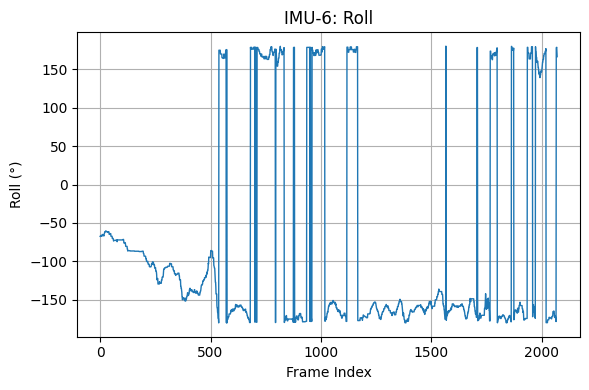

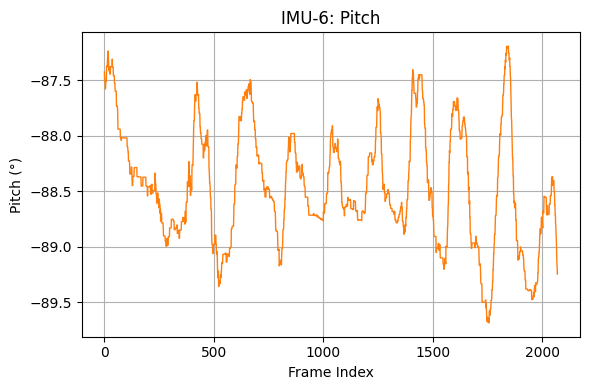

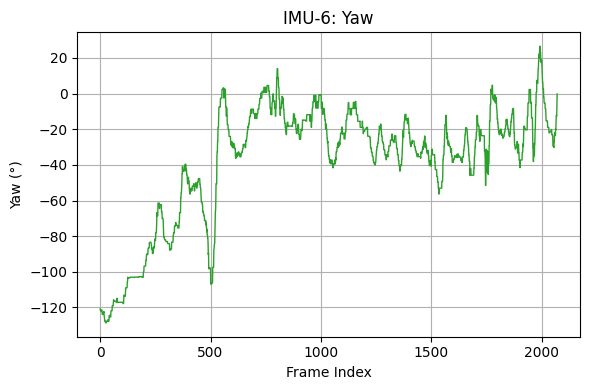

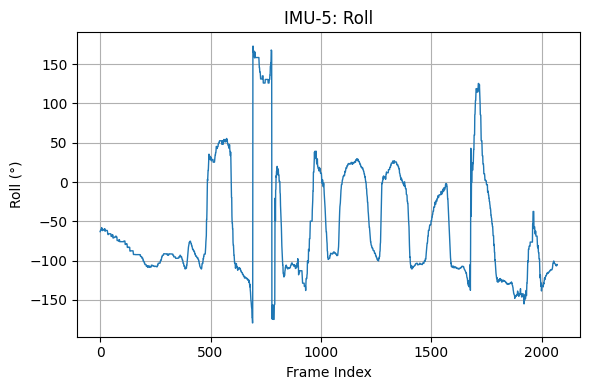

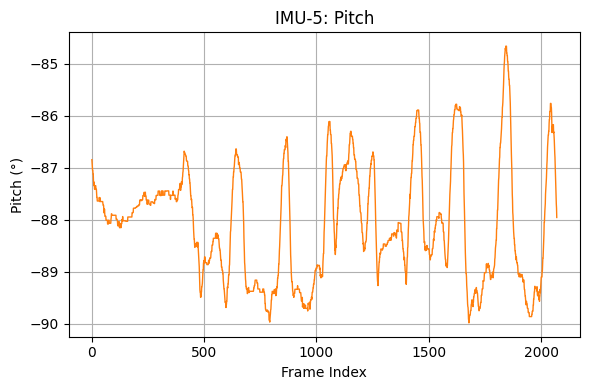

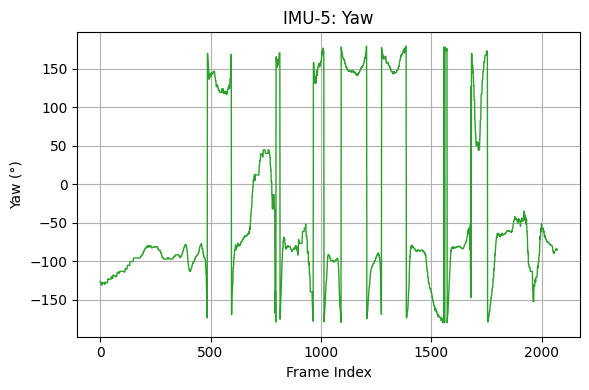

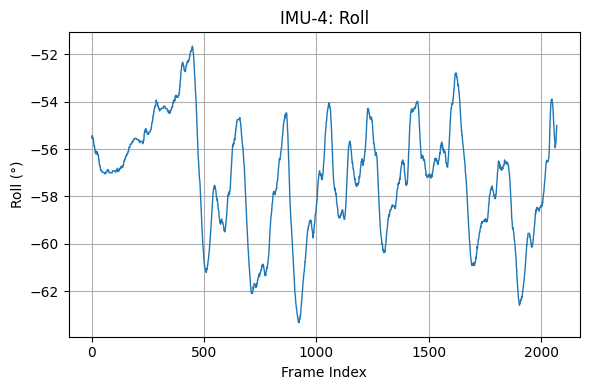

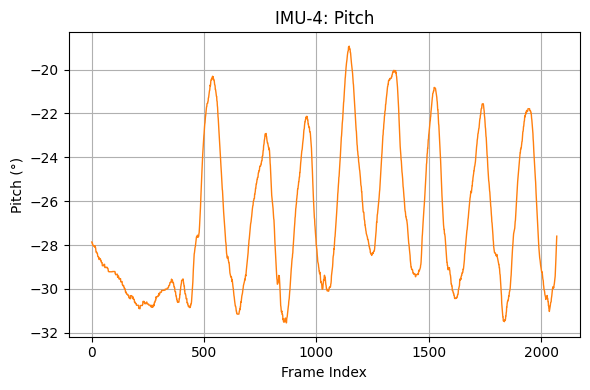

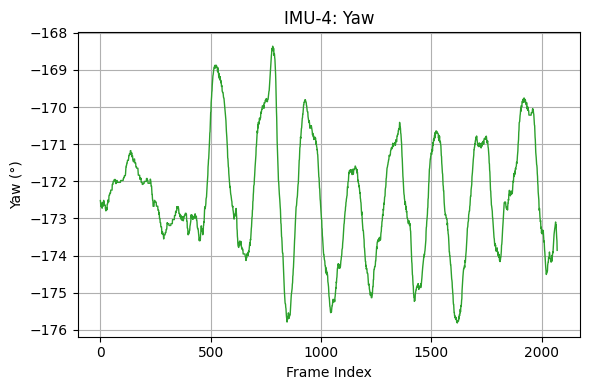

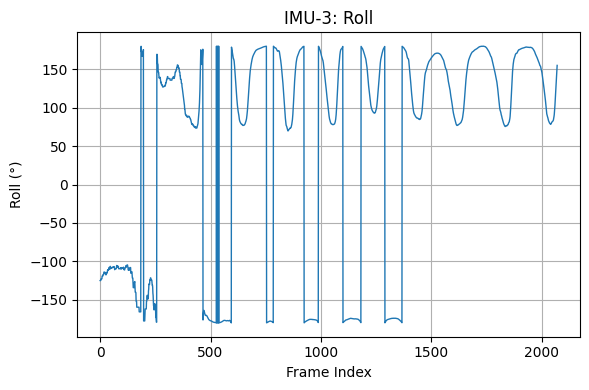

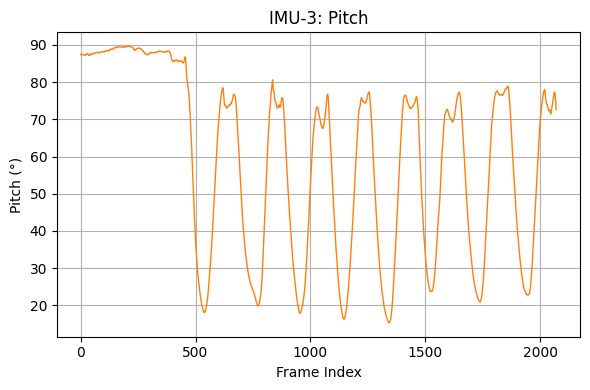

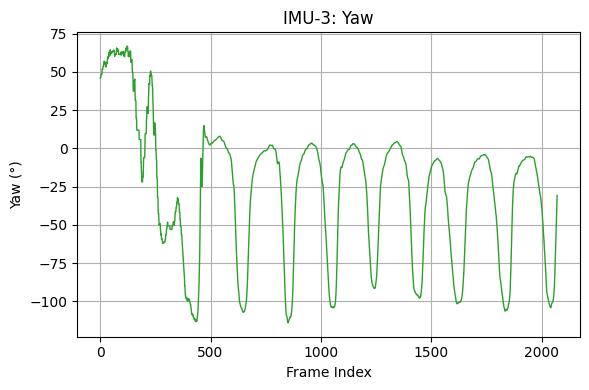

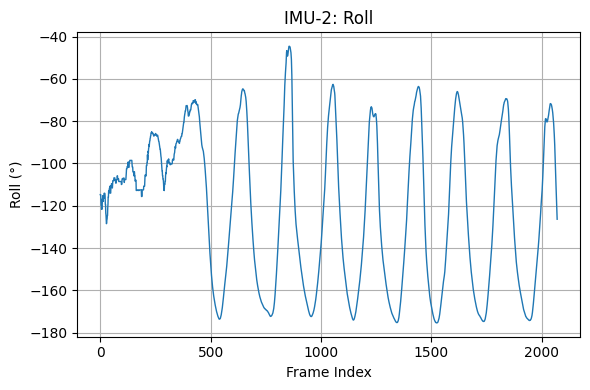

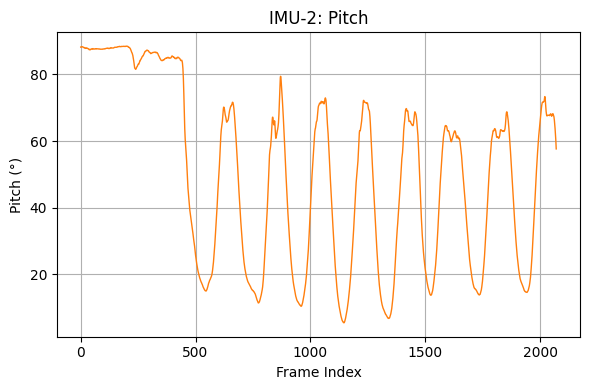

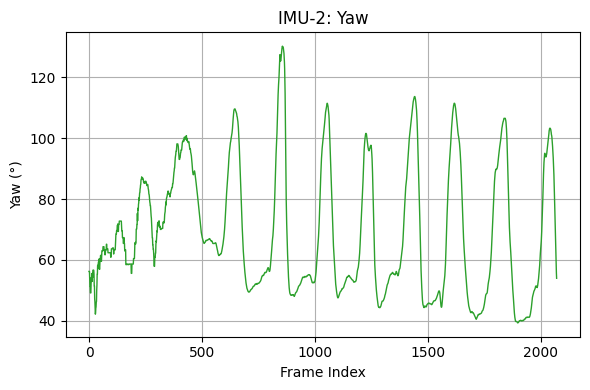

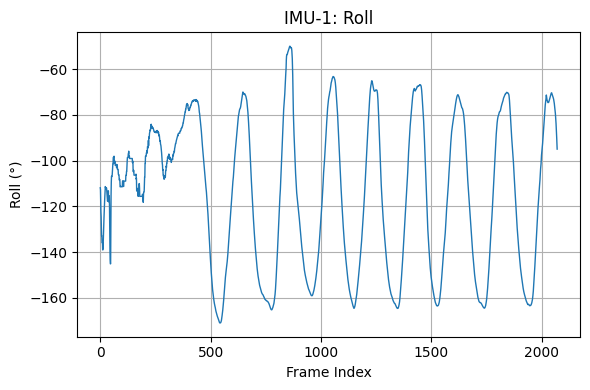

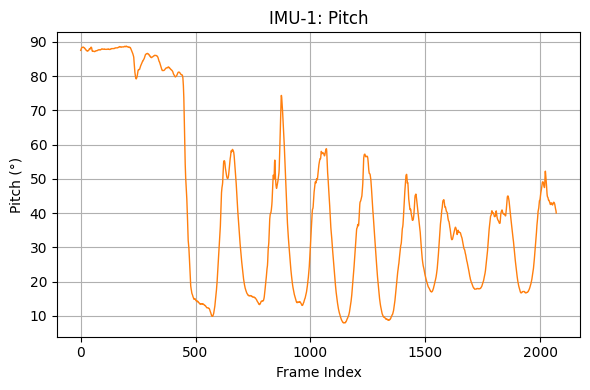

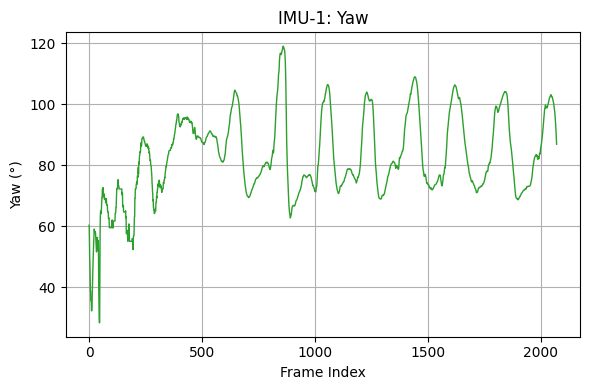

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# (Assume imu_ids, ROOT_ID, imu_hierarchy, unit_vectors,
#  processed_data, R_B0_to_S0, num_frames, etc. are already defined)
# --- Configuration / Constants --- #


# --- Calibration (compute R_B0_to_S0 for each available IMU) --- #

for frame in range(num_frames):
    # Extract the quaternion for IMU-6 (reference), reorder to [x, y, z, w]
    q_ref_raw = processed_data["IMU-6"].iloc[frame][["q1","q2","q3","q0"]].values


R_B0_to_S0 = {}
for imu in available_imus:
    # Take the mean of the first 2 seconds of quaternions as reference
    ref_quat_df = processed_data[imu].iloc[: fps * 2][['q0', 'q1', 'q2', 'q3']]
    
    ref_quat_6_df = processed_data["IMU-6"].iloc[: fps * 2][['q0', 'q1', 'q2', 'q3']]
    ref_quat_6 = ref_quat_6_df.mean().values  # [q0_mean, q1_mean, q2_mean, q3_mean]
    q_sensor_raw = ref_quat_df.mean().values  # [q0_mean, q1_mean, q2_mean, q3_mean]
    q_sensor = compute_relative_quaternion(ref_quat_6, q_sensor_raw)
    # scipy expects [x, y, z, w], so we reorder as [q1, q2, q3, q0]:
    R_S0_Gp = R.from_quat([q_sensor[1], q_sensor[2], q_sensor[3], q_sensor[0]])

    bone_vec = unit_vectors[imu]
    z_axis = np.array([0.0, 0.0, 1.0])
    rot_axis = np.cross(z_axis, bone_vec)
    print(f"Calibration for {imu}: bone vector = {bone_vec}, z-axis = {z_axis}, rot_axis = {rot_axis}")
    if np.linalg.norm(rot_axis) < 1e-6:
        R_B0_Gp = R.identity()
    else:
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(z_axis, bone_vec), -1.0, 1.0))
        R_B0_Gp = R.from_rotvec(rot_axis * angle)
    print(f"Calibration for {imu}: angle = {angle}" )
    # R_B0_to_S0 = R_S0_Gp⁻¹ * R_B0_Gp
    R_B0_to_S0[imu] = R_S0_Gp.inv() * R_B0_Gp


# --- 2) FORWARD KINEMATICS and RECORDING EULER ANGLES --- #
# Create a structure to hold roll, pitch, yaw for each IMU across frames
imu_euler = {
    imu: {"roll": [], "pitch": [], "yaw": []}
    for imu in imu_ids
}

positions = []  # (optional) if you still want segment positions
for frame in range(num_frames):
    seg_pos = {ROOT_ID: np.zeros(3)}
    R_Bt_Gp_dict = {}

    for imu in imu_ids:
        parent, dist = imu_hierarchy[imu]

        # Extract current quaternion [q0, q1, q2, q3]
        q_raw = processed_data[imu].iloc[frame][['q0', 'q1', 'q2', 'q3']].values
        q_row = compute_relative_quaternion(q_ref_raw, q_raw)
        # Convert to Rotation object (scipy expects [x, y, z, w])
        R_St_Gp = R.from_quat([q_row[1], q_row[2], q_row[3], q_row[0]])

        # Combine with calibration to get bone-to-global orientation
        R_Bt_Gp = R_St_Gp * R_B0_to_S0[imu]
        R_Bt_Gp_dict[imu] = R_Bt_Gp

        # Record Euler angles (roll, pitch, yaw) in degrees using 'xyz' convention
        roll, pitch, yaw = R_Bt_Gp.as_euler('xyz', degrees=True)
        imu_euler[imu]["roll"].append(roll)
        imu_euler[imu]["pitch"].append(pitch)
        imu_euler[imu]["yaw"].append(yaw)

        # (Optional) Compute and store segment endpoint positions
        world_vec = R_Bt_Gp.apply(unit_vectors[imu] * dist)
        seg_pos[imu] = seg_pos[parent] + world_vec

    positions.append((seg_pos, R_Bt_Gp_dict))

# Convert the recorded Euler lists into NumPy arrays for plotting
for imu in imu_ids:
    imu_euler[imu]["roll"]  = np.array(imu_euler[imu]["roll"])
    imu_euler[imu]["pitch"] = np.array(imu_euler[imu]["pitch"])
    imu_euler[imu]["yaw"]   = np.array(imu_euler[imu]["yaw"])

# Create a common time axis (frame indices)
time = np.arange(num_frames)

# --- 3) PLOTTING: Three Separate Figures per IMU (Roll, Pitch, Yaw) --- #
# Color mapping: roll → blue, pitch → orange, yaw → green
color_map = {"roll": "tab:blue", "pitch": "tab:orange", "yaw": "tab:green"}

for imu in imu_ids:
    for angle_name in ["roll", "pitch", "yaw"]:
        plt.figure(figsize=(6, 4))
        plt.plot(time, imu_euler[imu][angle_name],
                 color=color_map[angle_name], linewidth=1)
        plt.title(f"{imu}: {angle_name.capitalize()}")
        plt.xlabel("Frame Index")
        plt.ylabel(f"{angle_name.capitalize()} (°)")
        plt.grid(True)
        plt.tight_layout()

# Finally, display all figures
plt.show()


# IMU data after N Pose Calibration


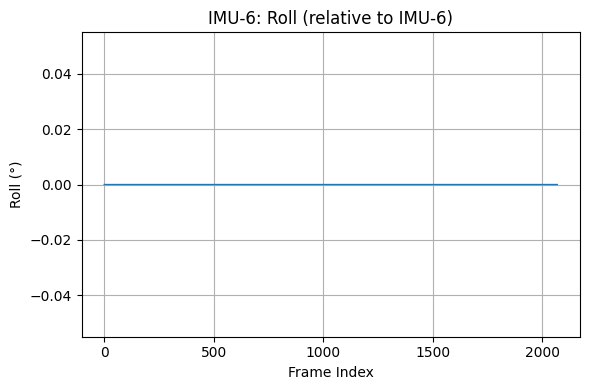

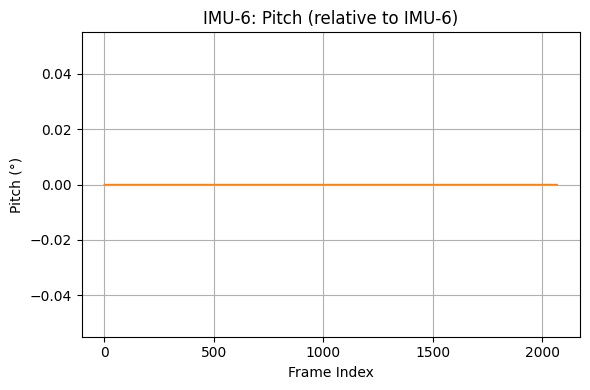

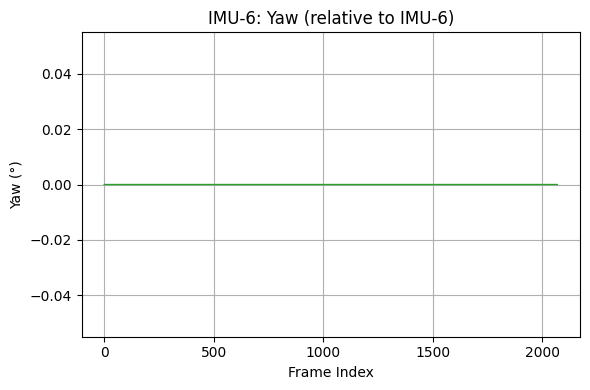

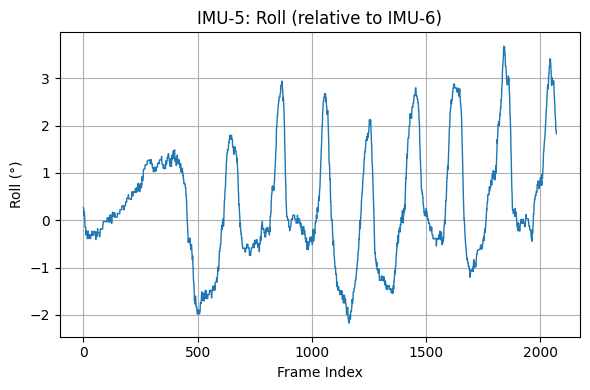

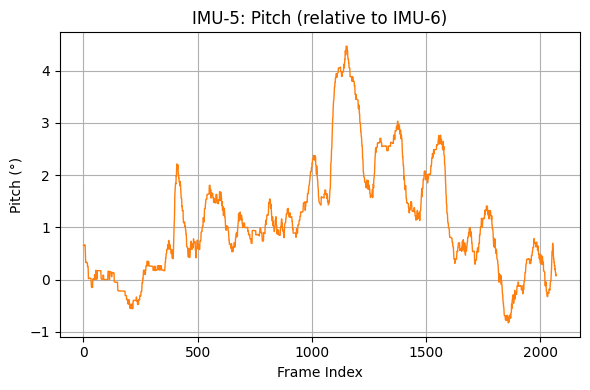

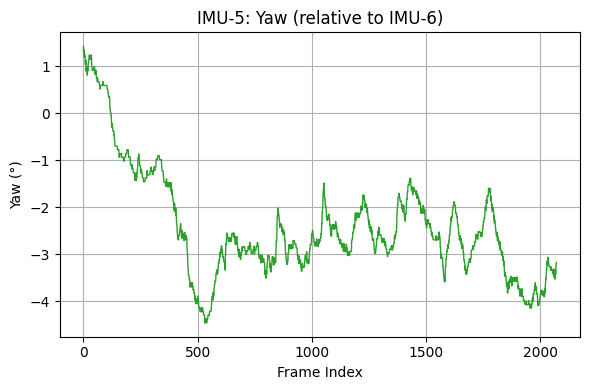

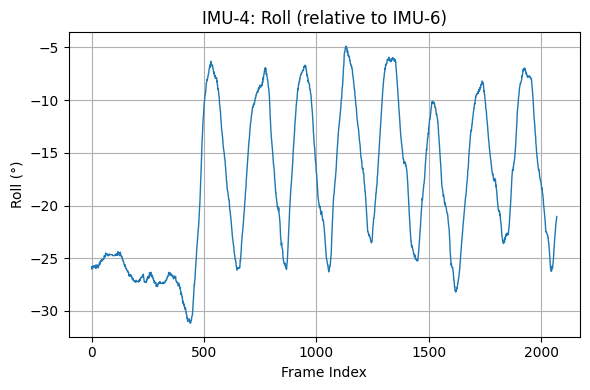

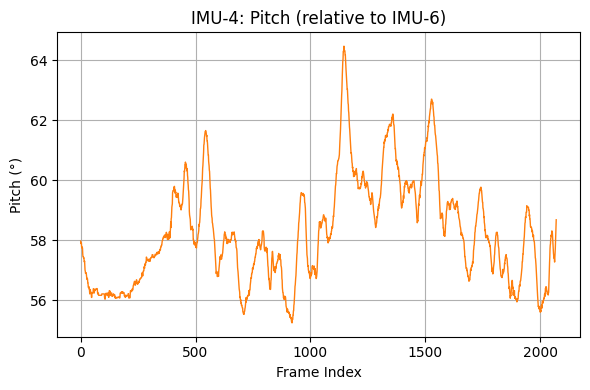

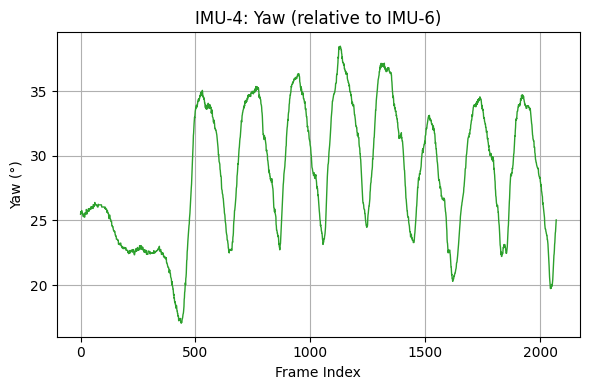

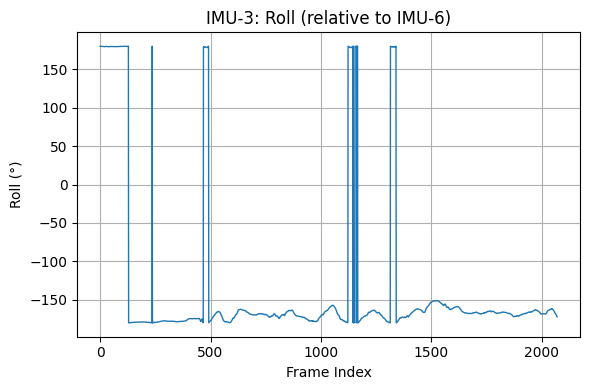

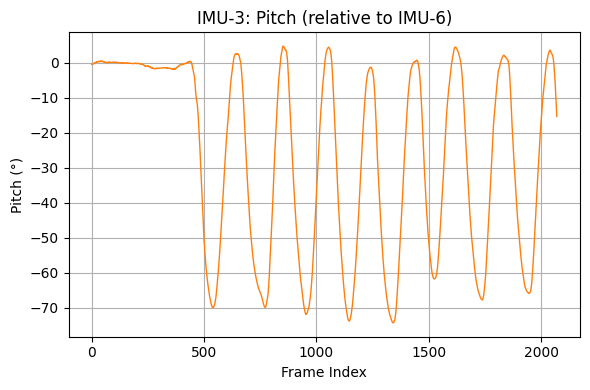

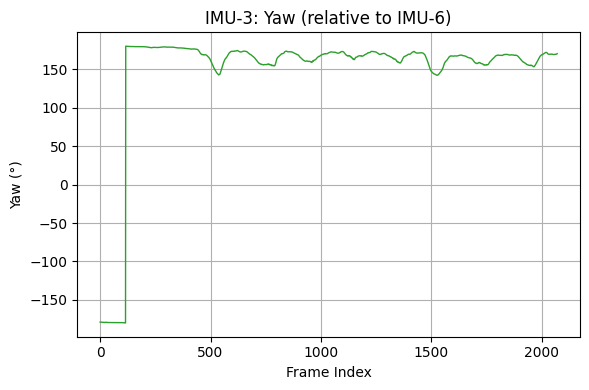

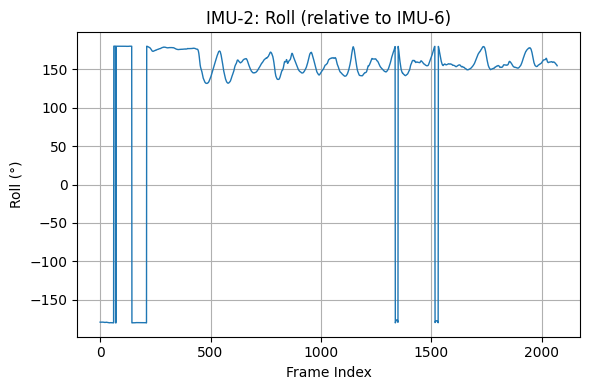

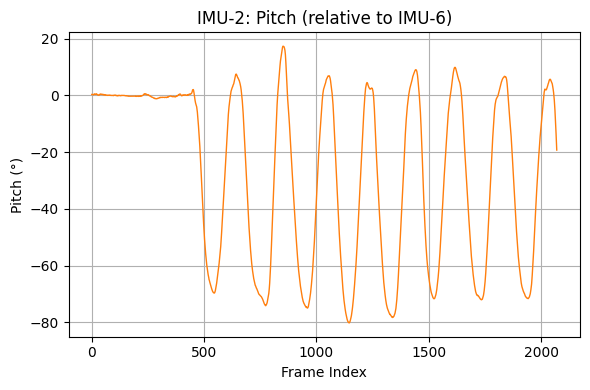

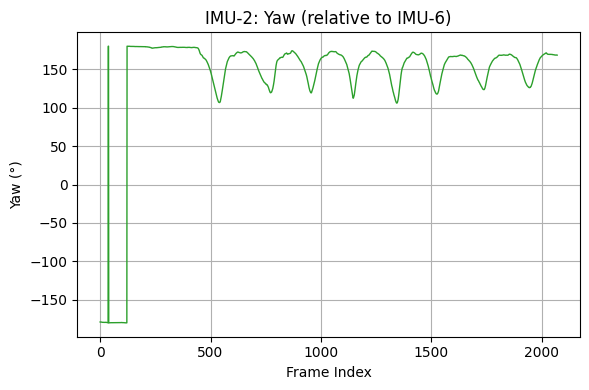

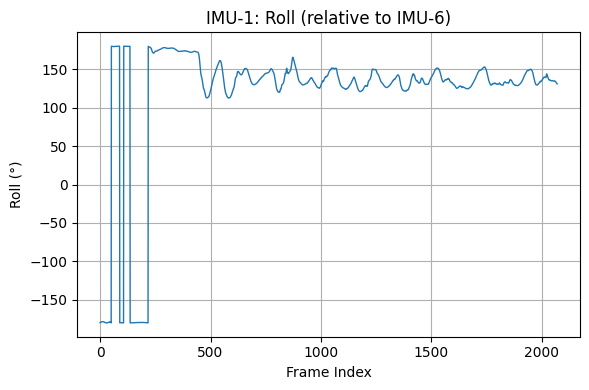

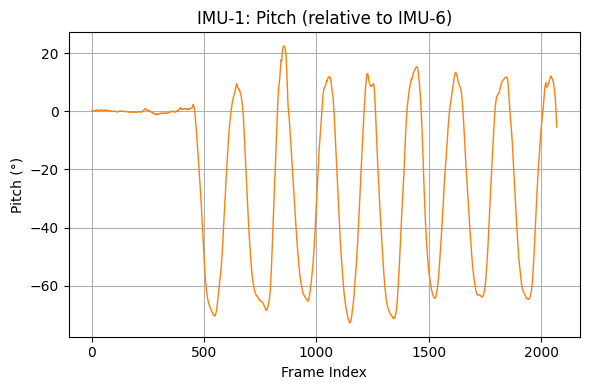

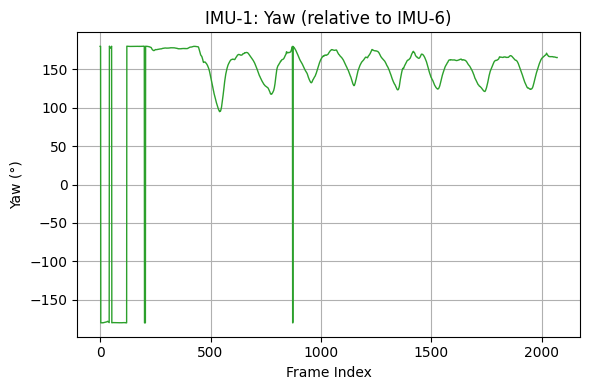

In [41]:

# --- Calibration (compute R_B0_to_S0 for each available IMU) --- #
R_B0_to_S0 = {}
for imu in available_imus:
    ref_quat_df = processed_data[imu].iloc[50: fps * 3][['q0', 'q1', 'q2', 'q3']]
    q_sensor = ref_quat_df.mean().values  # [q0_mean, q1_mean, q2_mean, q3_mean]
    R_S0_Gp = R.from_quat([q_sensor[1], q_sensor[2], q_sensor[3], q_sensor[0]])

    bone_vec = unit_vectors[imu]
    z_axis = np.array([0.0, 0.0, 1.0])
    rot_axis = np.cross(z_axis, bone_vec)

    if np.linalg.norm(rot_axis) < 1e-6:
        R_B0_Gp = R.identity()
    else:
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        angle = np.arccos(np.clip(np.dot(z_axis, bone_vec), -1.0, 1.0))
        R_B0_Gp = R.from_rotvec(rot_axis * angle)

    R_B0_to_S0[imu] = R_S0_Gp.inv() * R_B0_Gp

# --- 2) FORWARD KINEMATICS and RECORDING EULER ANGLES (relative to IMU‐6) --- #
imu_euler = {
    imu: {"roll": [], "pitch": [], "yaw": []}
    for imu in imu_ids
}

positions = []  # store segment positions relative to IMU‐6 frame
for frame in range(num_frames):
    # First compute each IMU’s absolute bone‐to‐global rotation
    R_Bt_Gp_dict = {}
    for imu in imu_ids:
        # Reorder [q0, q1, q2, q3] → [x, y, z, w]
        q_row = processed_data[imu].iloc[frame][['q0', 'q1', 'q2', 'q3']].values
        R_St_Gp = R.from_quat([q_row[1], q_row[2], q_row[3], q_row[0]])
        R_Bt_Gp = R_St_Gp * R_B0_to_S0[imu]
        R_Bt_Gp_dict[imu] = R_Bt_Gp

    # Use IMU‐6 as reference: compute its inverse once per frame
    R_ref = R_Bt_Gp_dict['IMU-6']
    R_ref_inv = R_ref.inv()

    # Now build segment positions and record Euler (all relative to IMU‐6)
    seg_pos = {'IMU-6': np.zeros(3)}  # IMU‐6 is the origin of its own frame
    for imu in imu_ids:
        parent, dist = imu_hierarchy[imu]
        R_abs = R_Bt_Gp_dict[imu]
        R_rel = R_ref_inv * R_abs

        # Record Euler angles (roll, pitch, yaw) of R_rel
        roll, pitch, yaw = R_rel.as_euler('xyz', degrees=True)
        imu_euler[imu]["roll"].append(roll)
        imu_euler[imu]["pitch"].append(pitch)
        imu_euler[imu]["yaw"].append(yaw)

        # Compute this IMU’s segment vector in IMU‐6’s frame
        world_vec = R_rel.apply(unit_vectors[imu] * dist)
        if imu == 'IMU-6':
            seg_pos[imu] = np.zeros(3)
        else:
            seg_pos[imu] = seg_pos[parent] + world_vec

    positions.append((seg_pos, R_Bt_Gp_dict))

# Convert recorded Euler lists into NumPy arrays for plotting
for imu in imu_ids:
    imu_euler[imu]["roll"]  = np.array(imu_euler[imu]["roll"])
    imu_euler[imu]["pitch"] = np.array(imu_euler[imu]["pitch"])
    imu_euler[imu]["yaw"]   = np.array(imu_euler[imu]["yaw"])

time = np.arange(num_frames)

# --- 3) PLOTTING: Three Separate Figures per IMU (Roll, Pitch, Yaw) --- #
color_map = {"roll": "tab:blue", "pitch": "tab:orange", "yaw": "tab:green"}

for imu in imu_ids:
    for angle_name in ["roll", "pitch", "yaw"]:
        plt.figure(figsize=(6, 4))
        plt.plot(time, imu_euler[imu][angle_name],
                 color=color_map[angle_name], linewidth=1)
        plt.title(f"{imu}: {angle_name.capitalize()} (relative to IMU‐6)")
        plt.xlabel("Frame Index")
        plt.ylabel(f"{angle_name.capitalize()} (°)")
        plt.grid(True)
        plt.tight_layout()

plt.show()


# Animation Code


Animation saved as: animation_IMU3_roll_pitch_yaw.mov


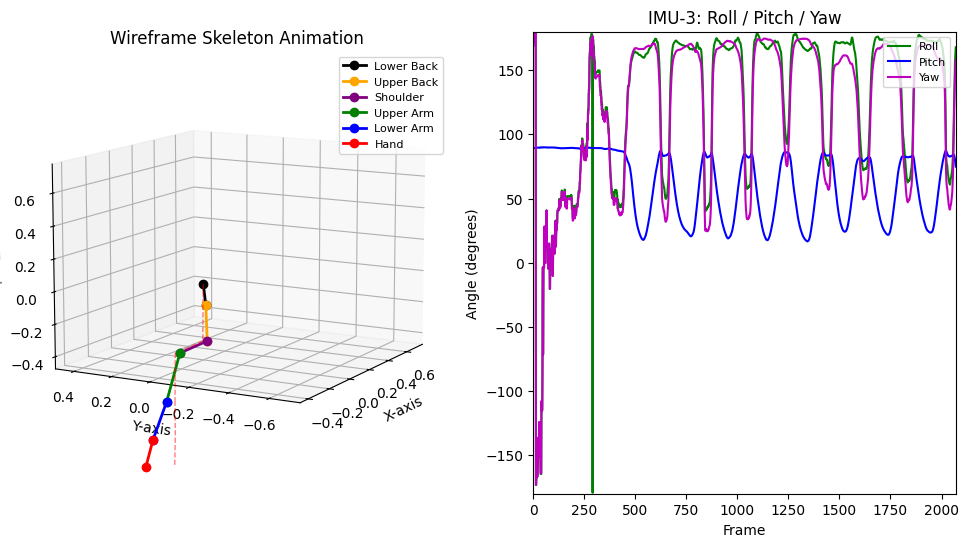

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers

# -----------------------------------------------------------------------------
# -- ASSUMPTION: Prior to this block, you have already run your calibration + forward‐kinematics
#    and built these two variables exactly as in your first snippet:
#
#    positions = [
#        ({'IMU-6': <3‐vector>, 'IMU-5': <3‐vector>, ...}, { ... }),      # frame 0
#        ({'IMU-6': <3‐vector>, 'IMU-5': <3‐vector>, ...}, { ... }),      # frame 1
#        ...
#    ]
#
#    imu_euler = {
#        'IMU-1': {'roll': np.array([...]), 'pitch': np.array([...]), 'yaw': np.array([...])},
#        'IMU-2': {'roll': np.array([...]), 'pitch': np.array([...]), 'yaw': np.array([...])},
#        ...
#        'IMU-6': {'roll': np.array([...]), 'pitch': np.array([...]), 'yaw': np.array([...])},
#    }
#
#    imu_ids      = ['IMU-6','IMU-5','IMU-4','IMU-3','IMU-2','IMU-1']
#    imu_hierarchy = {
#        'IMU-6': ('ROOT',    lengths['IMU-6']),
#        'IMU-5': ('IMU-6',   lengths['IMU-5']),
#        'IMU-4': ('IMU-5',   lengths['IMU-4']),
#        'IMU-3': ('IMU-4',   lengths['IMU-3']),
#        'IMU-2': ('IMU-3',   lengths['IMU-2']),
#        'IMU-1': ('IMU-2',   lengths['IMU-1']),
#    }
#
#    # Number of frames:
#    num_frames = len(positions)
# -----------------------------------------------------------------------------

# 1) Extract just the seg_pos dictionaries for animation
positions_list = [seg_pos for (seg_pos, _) in positions]
ref_pos        = positions_list[0]   # static reference pose at frame 0

# 2) Set up the figure and axes
fig = plt.figure(figsize=(12, 6))

# 3D skeleton subplot
ax3d = fig.add_subplot(121, projection='3d')
ax3d.set_title("Wireframe Skeleton Animation")
ax3d.set_xlabel("X-axis")
ax3d.set_ylabel("Y-axis")
ax3d.set_zlabel("Z-axis")

# 2D angles subplot
axAng = fig.add_subplot(122)
axAng.set_xlim(0, num_frames)
axAng.set_ylim(-180, 180)   # Cover full possible range of Euler outputs
axAng.set_xlabel("Frame")
axAng.set_ylabel("Angle (degrees)")
axAng.set_title("IMU‐3: Roll / Pitch / Yaw")

# 3) Define line objects for each segment (colored)
imu_colors = {
    "IMU-1": "red",
    "IMU-2": "blue",
    "IMU-3": "green",
    "IMU-4": "purple",
    "IMU-5": "orange",
    "IMU-6": "black",
}
imu_labels = {
    "IMU-1": "Hand",
    "IMU-2": "Lower Arm",
    "IMU-3": "Upper Arm",
    "IMU-4": "Shoulder",
    "IMU-5": "Upper Back",
    "IMU-6": "Lower Back",
}

lines     = {}
ref_lines = {}

for imu, (parent, _) in imu_hierarchy.items():
    color = imu_colors.get(imu, "gray")
    label = imu_labels.get(imu, imu)
    # Main (solid) line for the animated skeleton
    line_obj, = ax3d.plot([], [], [], 'o-', color=color, label=label, lw=2)
    lines[imu] = line_obj

    # Reference (dashed, red) line to show the “neutral” pose
    ref_obj, = ax3d.plot([], [], [], 'r--', alpha=0.5, lw=1)
    ref_lines[imu] = ref_obj

ax3d.legend(loc='upper right', fontsize=8, frameon=True)

# 4) Prepare the 2D‐angle plots: one line each for roll, pitch, yaw of IMU‐3
imu_to_plot = "IMU-3"
roll_line,  = axAng.plot([], [], 'g-', label="Roll")
pitch_line, = axAng.plot([], [], 'b-', label="Pitch")
yaw_line,   = axAng.plot([], [], 'm-', label="Yaw")
axAng.legend(loc='upper right', fontsize=8)


# 5) The update function for FuncAnimation
def update_anim(frame_idx):
    """
    For each frame:
      - Draw the static “reference” skeleton in dashed red (from ref_pos).
      - Draw the current skeleton (seg_pos = positions_list[frame_idx]) in solid colors.
      - Update the 2D plot of roll/pitch/yaw for IMU‐3 up to this frame.
    """
    seg_pos = positions_list[frame_idx]

    # --- (a) Update reference skeleton (always drawn from ref_pos) ---
    for imu, (parent, _) in imu_hierarchy.items():
        if imu in ref_pos and parent in ref_pos:
            p_ref = ref_pos[parent]
            c_ref = ref_pos[imu]
            ref_lines[imu].set_data([p_ref[0], c_ref[0]], [p_ref[1], c_ref[1]])
            ref_lines[imu].set_3d_properties([p_ref[2], c_ref[2]])

    # --- (b) Update animated skeleton for this frame (seg_pos) ---
    for imu, (parent, _) in imu_hierarchy.items():
        if imu in seg_pos and parent in seg_pos:
            p_pos = seg_pos[parent]
            c_pos = seg_pos[imu]
            lines[imu].set_data([p_pos[0], c_pos[0]], [p_pos[1], c_pos[1]])
            lines[imu].set_3d_properties([p_pos[2], c_pos[2]])

    # --- (c) Update 2D angle curves (roll/pitch/yaw) for IMU‐3 up to current frame ---
    #    We assume imu_euler[imu_to_plot]["roll"] is a NumPy array of shape (num_frames,).
    r_series = imu_euler[imu_to_plot]["roll"]
    p_series = imu_euler[imu_to_plot]["pitch"]
    y_series = imu_euler[imu_to_plot]["yaw"]

    idxs = np.arange(frame_idx + 1)
    roll_line.set_data(idxs, r_series[: frame_idx + 1])
    pitch_line.set_data(idxs, p_series[: frame_idx + 1])
    yaw_line.set_data(idxs, y_series[: frame_idx + 1])

    # Rescale the 2D axes if needed
    axAng.relim()
    axAng.autoscale_view()

    # Return everything that was modified
    artists = list(lines.values()) + list(ref_lines.values()) + [roll_line, pitch_line, yaw_line]
    return artists


# 6) Fix the 3D axes limits and viewing angle (just like you had)
ax3d.set_xlim(-0.1, 0.4)
ax3d.set_ylim(-0.75, 0.5)
ax3d.set_zlim(-0.1, 0.4)
ax3d.view_init(elev=11, azim=-151)

# Utility to force equal aspect in 3D:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max(x_range, y_range, z_range)

    x_mid = np.mean(x_limits)
    y_mid = np.mean(y_limits)
    z_mid = np.mean(z_limits)
    ax.set_xlim3d([x_mid - max_range/2, x_mid + max_range/2])
    ax.set_ylim3d([y_mid - max_range/2, y_mid + max_range/2])
    ax.set_zlim3d([z_mid - max_range/2, z_mid + max_range/2])

set_axes_equal(ax3d)


# 7) Create the animation object
ani = FuncAnimation(
    fig,
    update_anim,
    frames=num_frames,
    interval=1000/30,    # roughly 30 FPS
    blit=False
)

# 8) (Optional) Save to disk as a movie. Adjust paths + fps as needed:
Writer = writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Your Name'), bitrate=1800)
ani_name = f"animation_IMU3_roll_pitch_yaw.mov"
ani_path = os.path.join("/home/jafarid/code/fusion/Results/", ani_name)
ani.save(ani_path, writer=writer)
print("Animation saved as:", ani_name)

# 9) Finally, display it
plt.show()


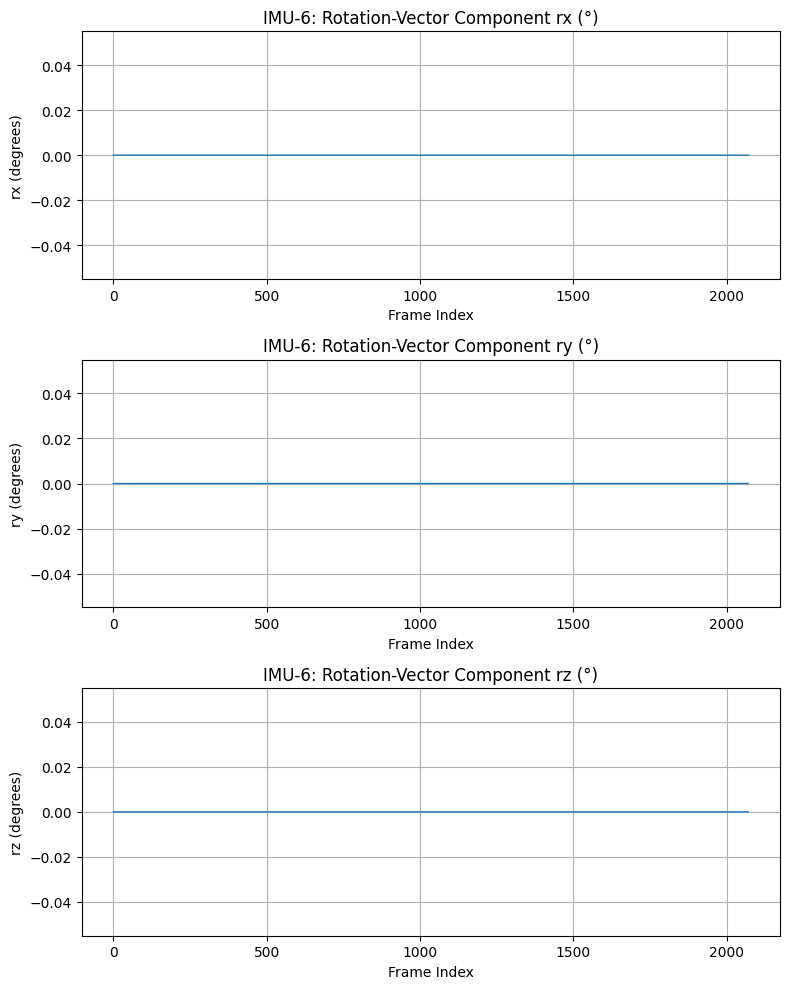

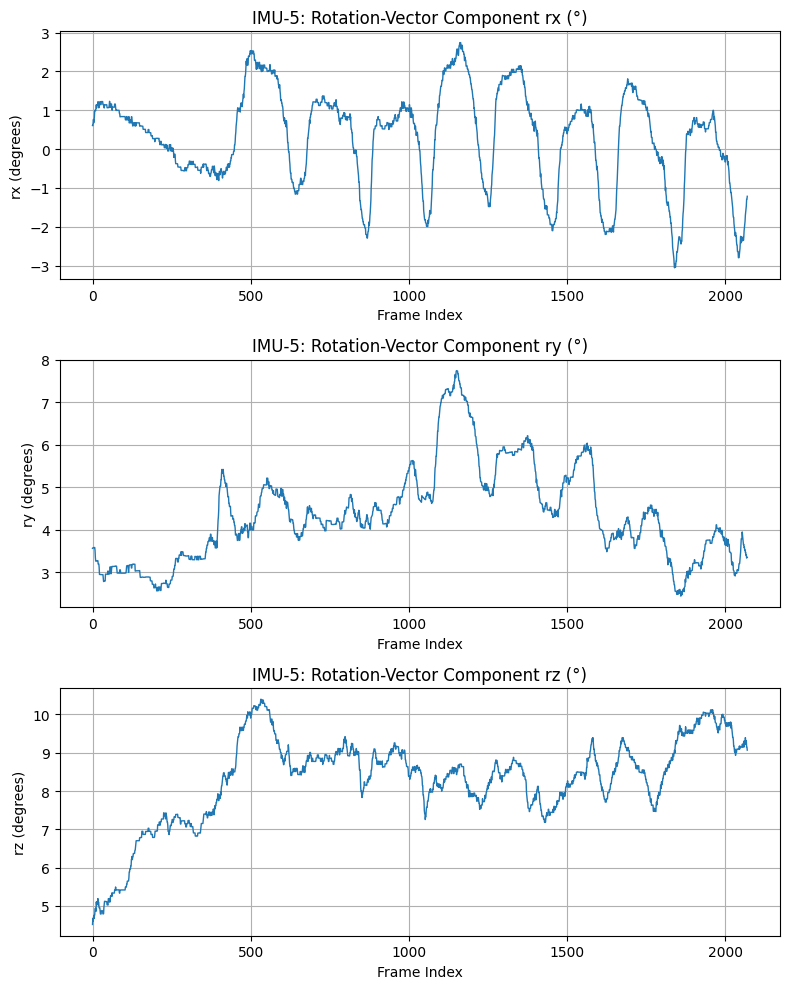

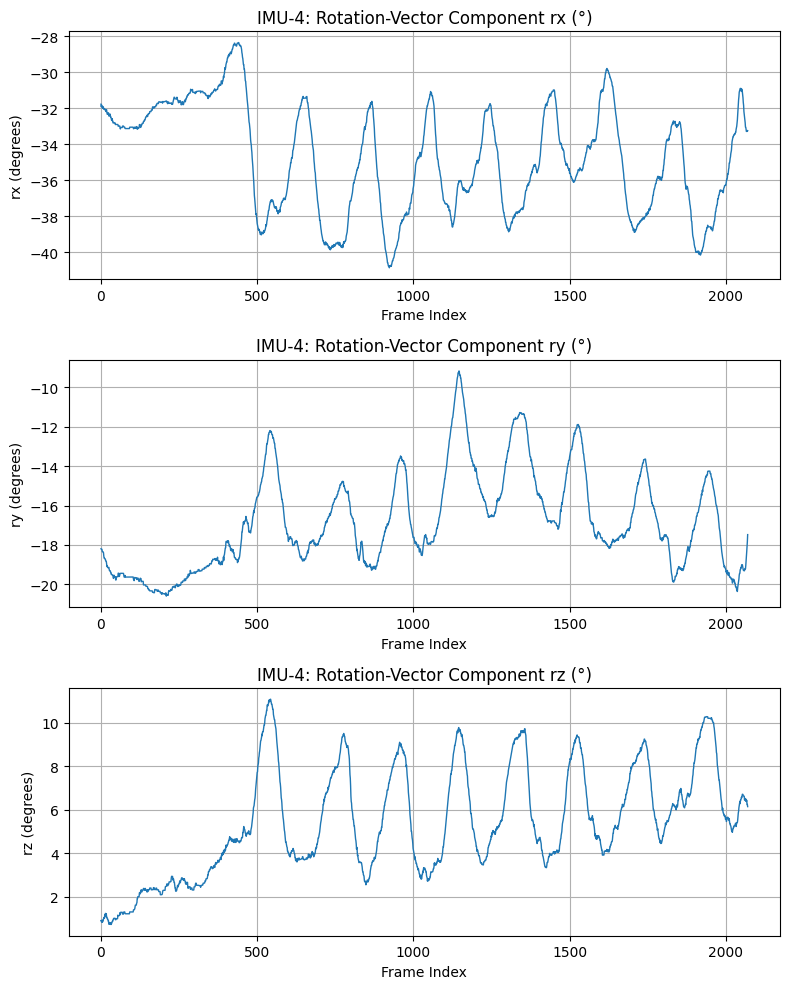

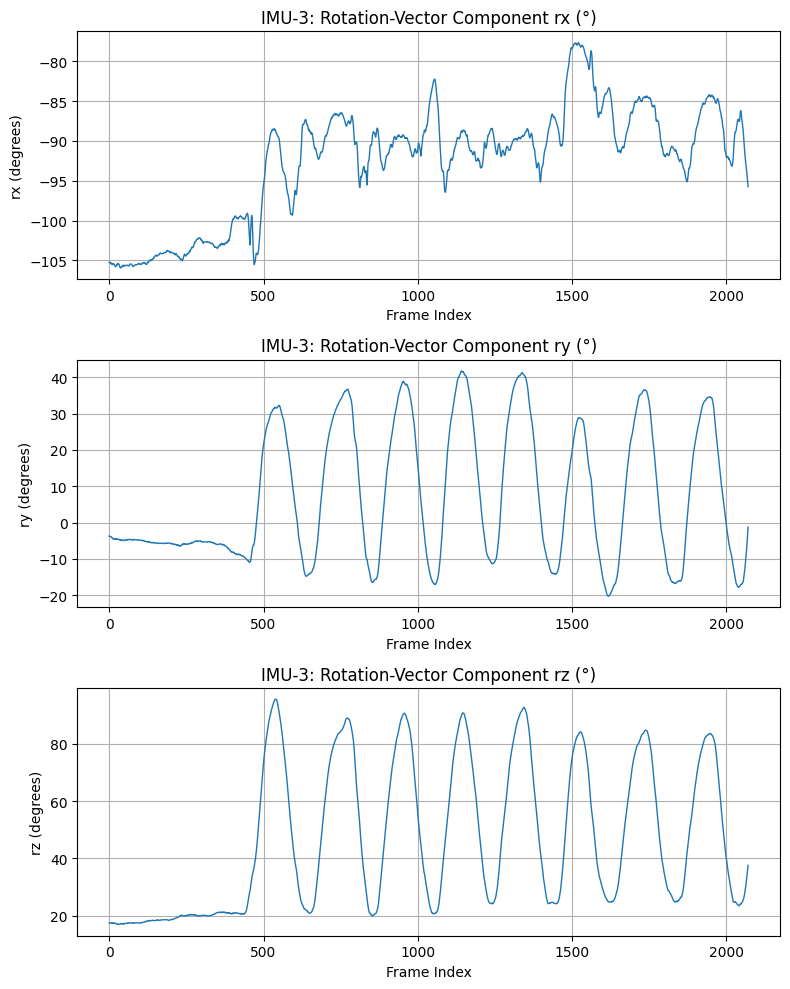

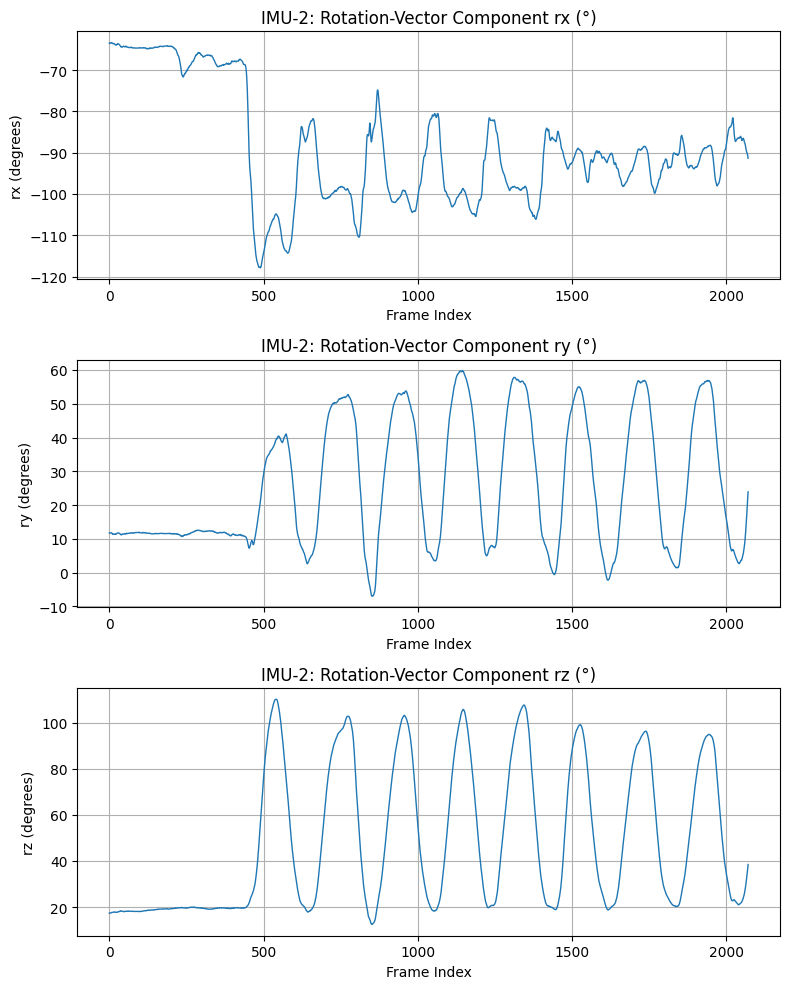

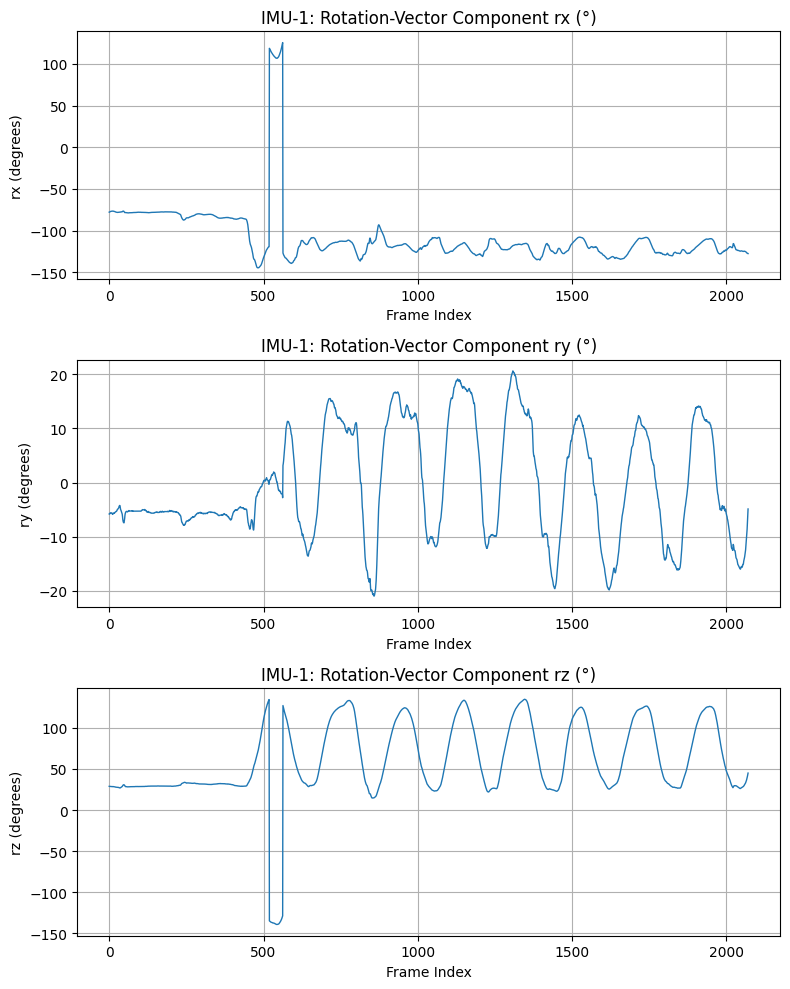

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ─── Assumptions ───────────────────────────────────────────────────────────────
# • `processed_data` is a dict with keys "IMU-1" … "IMU-6", each a pandas DataFrame containing
#   quaternion columns ["q0","q1","q2","q3"] per frame.
# • `num_frames` is the integer number of frames to process (same length for all).
# • We want IMU-6 as the reference: every other IMU’s orientation will be R_ref⁻¹ * R_imu.
# • We will store, for each IMU, the 3-component rotation-vector [rx, ry, rz] at each frame.
# ────────────────────────────────────────────────────────────────────────────────

imu_ids = ['IMU-6','IMU-5','IMU-4','IMU-3','IMU-2','IMU-1']
n_imus  = len(imu_ids)

# 1) Pre-allocate storage:
#    rotvec_records[imu_idx] will be a (num_frames × 3) array of rotation-vector components (in radians)
rotvec_records = np.zeros((n_imus, num_frames, 3), dtype=np.float64)

# 2) Build a lookup from imu_id → array index
imu_to_idx = { imu: idx for idx, imu in enumerate(imu_ids) }

# 3) Loop over frames, compute relative R_rel = R_ref⁻¹ * R_imu, then extract rotvec
for frame in range(num_frames):
    # — Extract IMU-6 quaternion ([x,y,z,w]) at this frame
    ref_row = processed_data["IMU-6"].iloc[frame]
    q_ref = np.array([ref_row["q1"], ref_row["q2"], ref_row["q3"], ref_row["q0"]])
    R_ref = R.from_quat(q_ref)        # maps IMU-6_body → global
    R_ref_inv = R_ref.inv()

    for imu in imu_ids:
        idx = imu_to_idx[imu]
        imu_row = processed_data[imu].iloc[frame]
        q_raw = np.array([imu_row["q1"], imu_row["q2"], imu_row["q3"], imu_row["q0"]])
        R_imu = R.from_quat(q_raw)    # maps this_IMU_body → global

        # Compute relative rotation: IMU’s orientation in IMU-6’s local frame
        R_rel = R_ref_inv * R_imu

        # Extract the rotation-vector (axis × angle) in radians
        rotvec = R_rel.as_rotvec()    # shape (3,)
        rotvec_records[idx, frame, :] = rotvec

# 4) Now each imu has rotvec_records[imu_idx] shaped (num_frames, 3).
#    You can plot the three components (rx, ry, rz) over time, or convert to degrees:
time = np.arange(num_frames)
deg_factor = 180.0 / np.pi

for imu in imu_ids:
    idx = imu_to_idx[imu]
    data_rv = rotvec_records[idx]       # (num_frames, 3) in radians
    data_rv_deg = data_rv * deg_factor  # convert each component to degrees

    fig, axes = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(8, 10),
        squeeze=True
    )

    for i, comp in enumerate(['rx', 'ry', 'rz']):
        ax = axes[i]
        ax.plot(time, data_rv_deg[:, i], linewidth=1)
        ax.set_title(f"{imu}: Rotation-Vector Component {comp} (°)")
        ax.set_xlabel("Frame Index")
        ax.set_ylabel(f"{comp} (degrees)")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


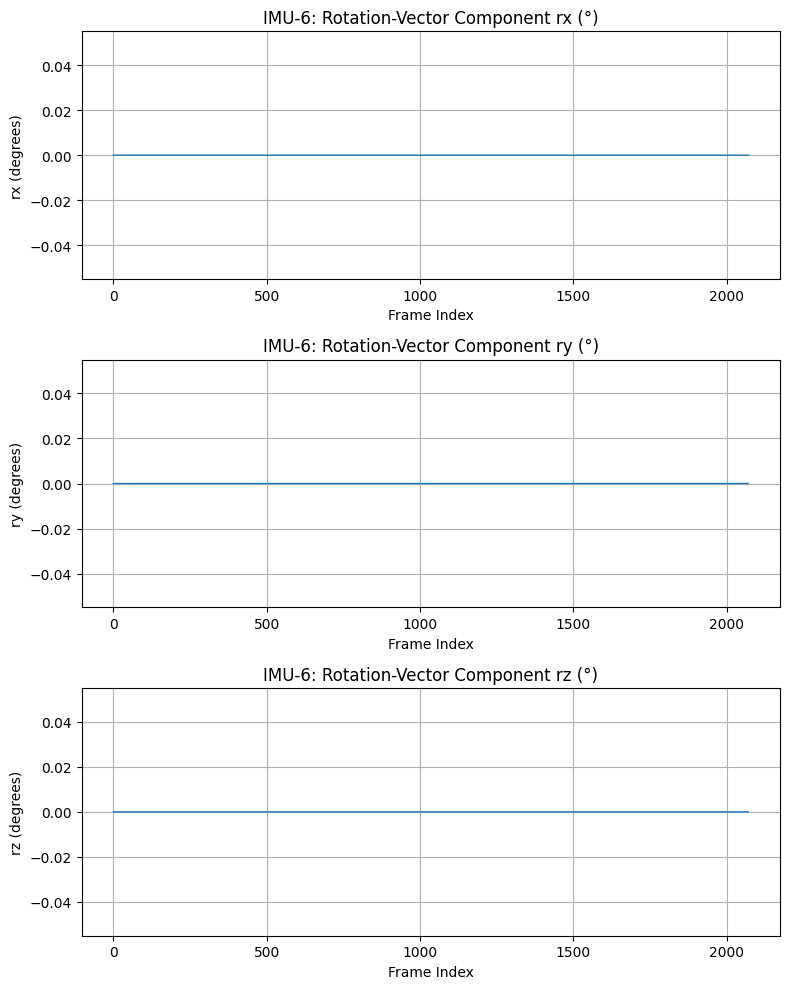

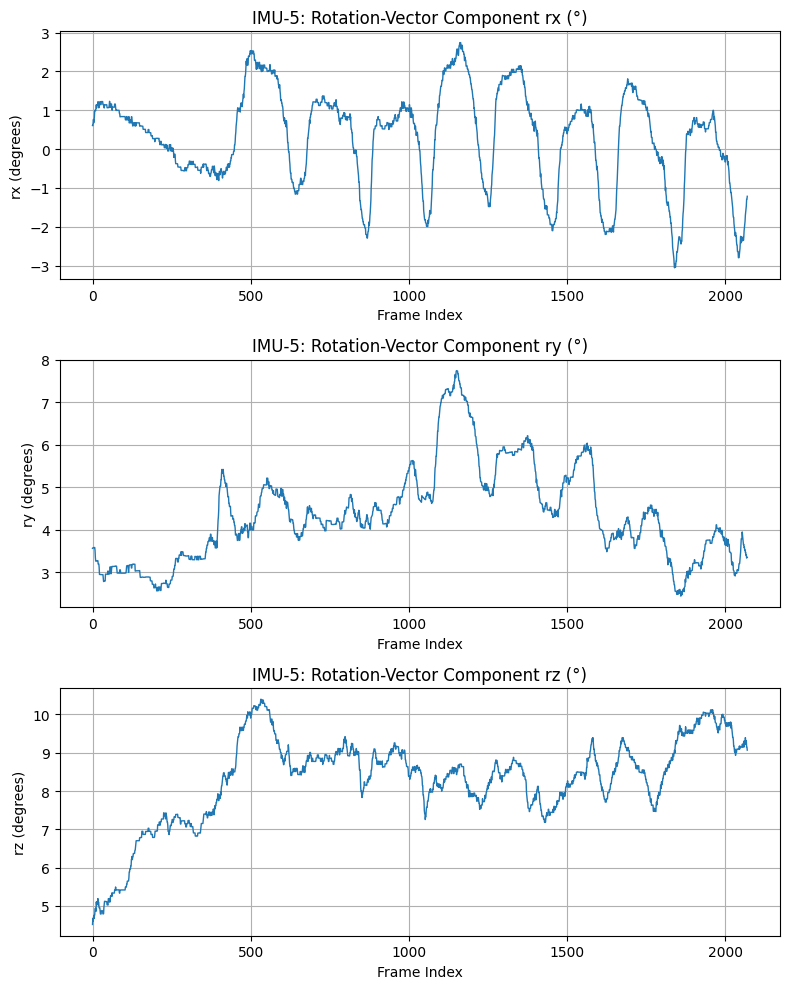

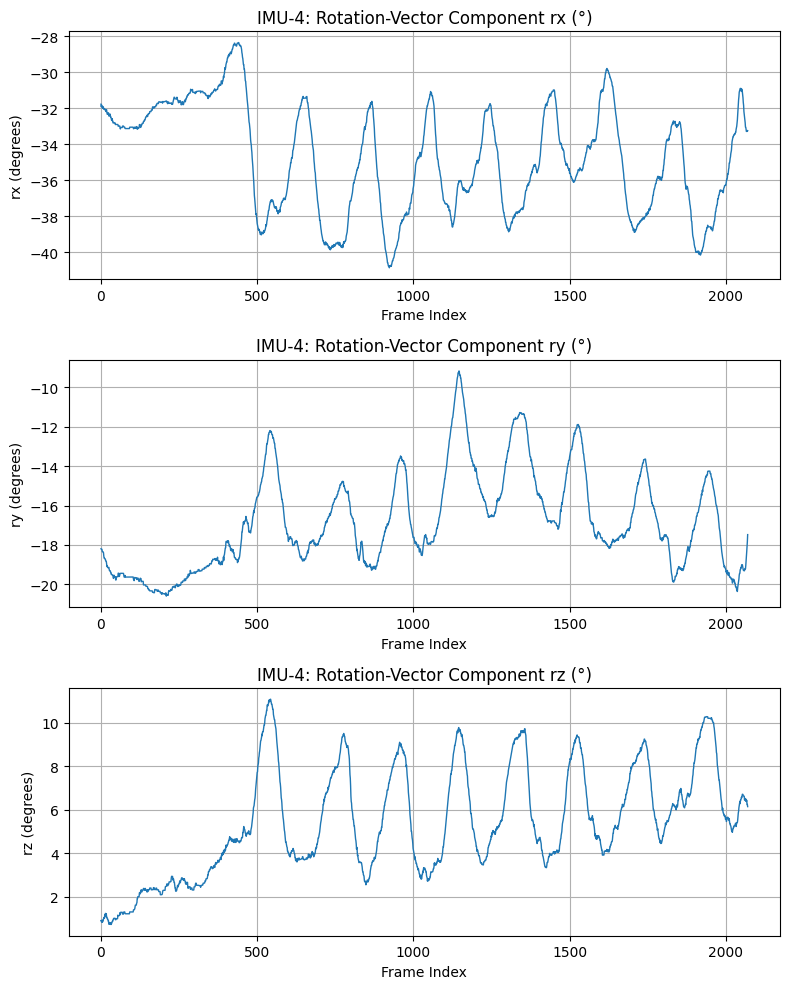

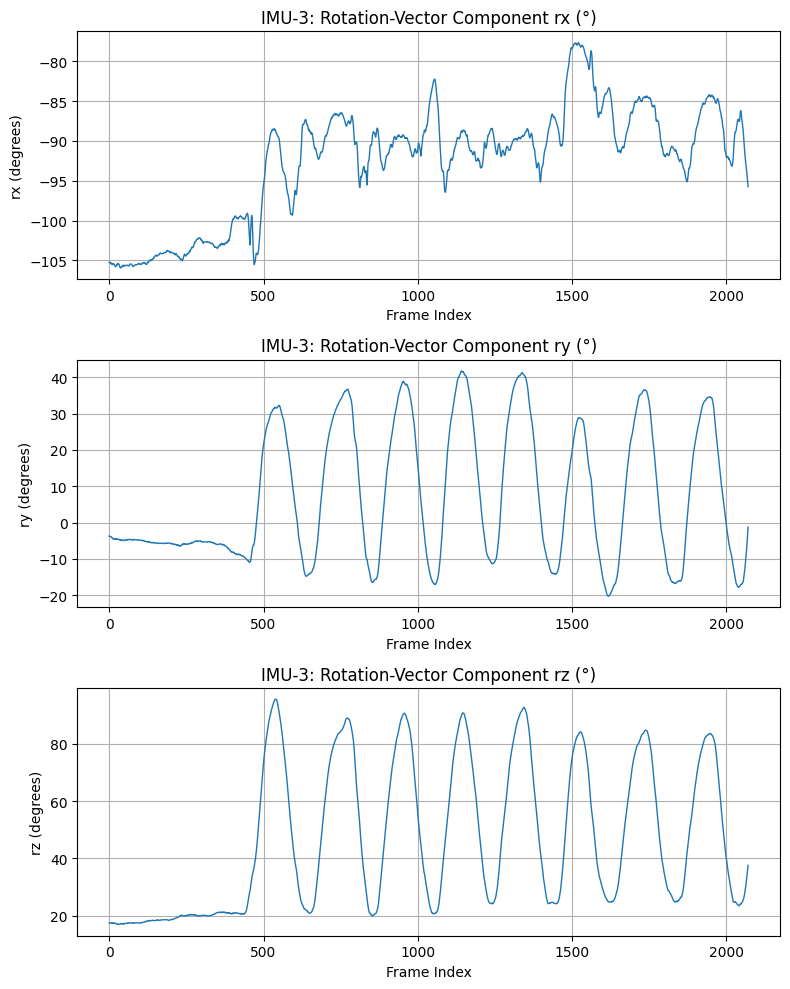

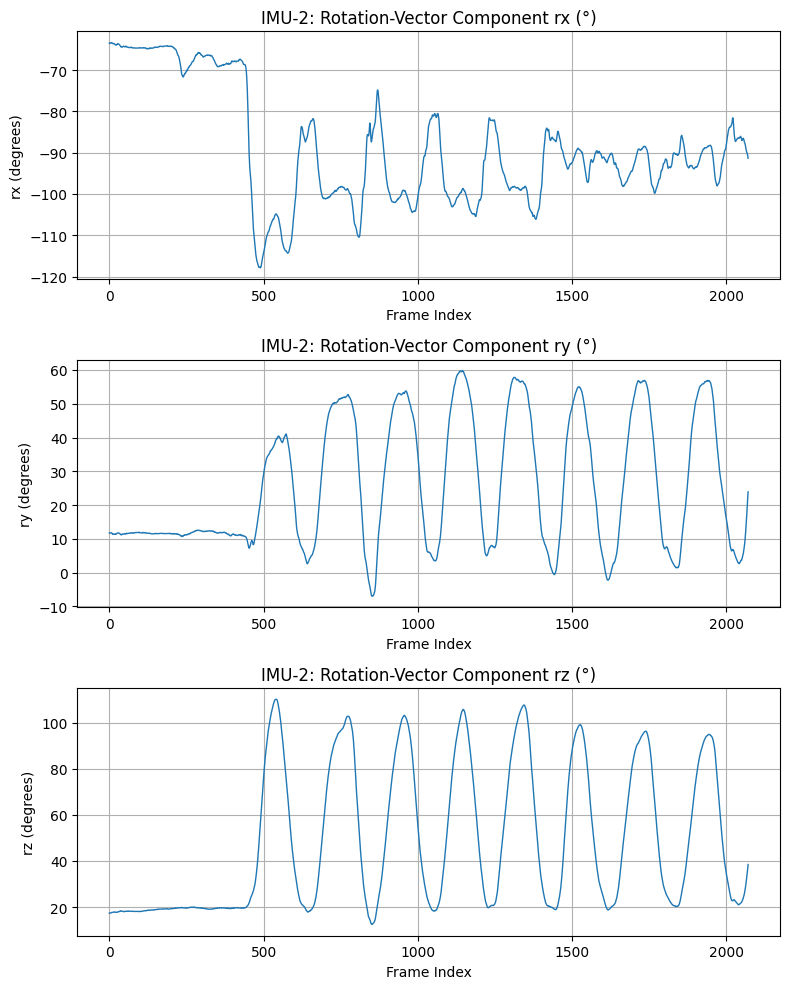

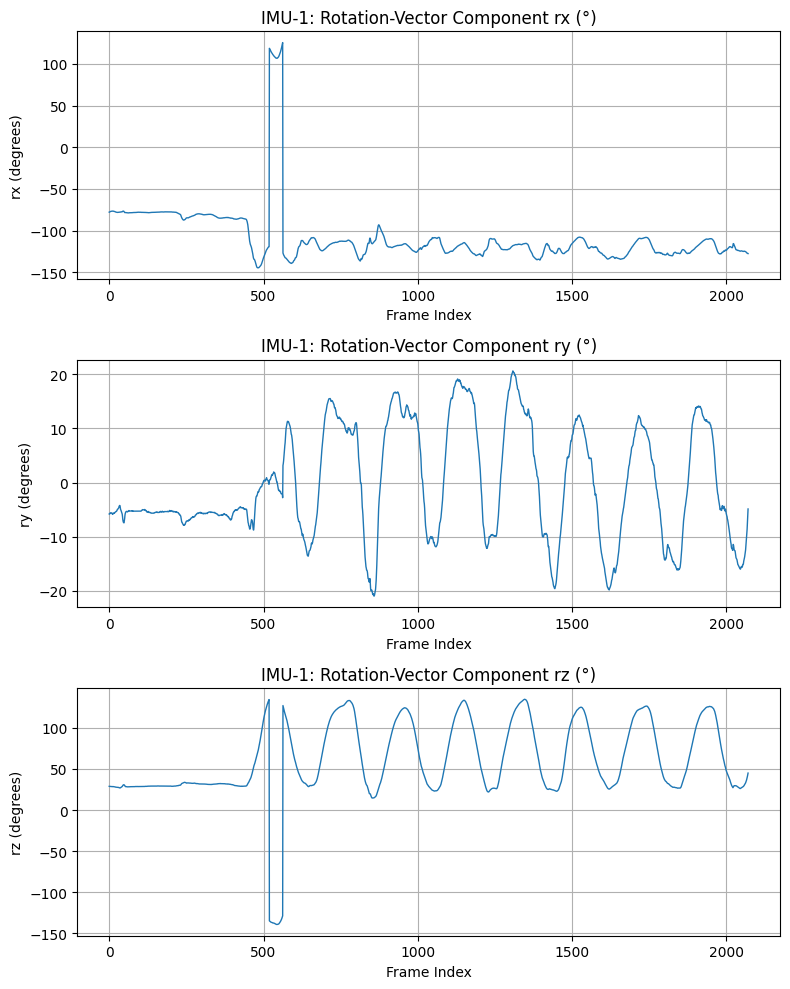

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ─── Assumptions ───────────────────────────────────────────────────────────────
# • `processed_data` is a dict with keys "IMU-1" … "IMU-6", each a pandas DataFrame containing
#   quaternion columns ["q0","q1","q2","q3"] per frame.
# • `num_frames` is the integer number of frames to process (same length for all).
# • We want IMU-6 as the reference: every other IMU’s orientation will be R_ref⁻¹ * R_imu.
# • We will store, for each IMU, the 3-component rotation-vector [rx, ry, rz] at each frame.
# ────────────────────────────────────────────────────────────────────────────────

imu_ids = ['IMU-6','IMU-5','IMU-4','IMU-3','IMU-2','IMU-1']
n_imus  = len(imu_ids)

# 1) Pre-allocate storage:
#    rotvec_records[imu_idx] will be a (num_frames × 3) array of rotation-vector components (in radians)
rotvec_records = np.zeros((n_imus, num_frames, 3), dtype=np.float64)

# 2) Build a lookup from imu_id → array index
imu_to_idx = { imu: idx for idx, imu in enumerate(imu_ids) }

# 3) Loop over frames, compute relative R_rel = R_ref⁻¹ * R_imu, then extract rotvec
for frame in range(num_frames):
    # — Extract IMU-6 quaternion ([x,y,z,w]) at this frame
    ref_row = processed_data["IMU-6"].iloc[frame]
    q_ref = np.array([ref_row["q1"], ref_row["q2"], ref_row["q3"], ref_row["q0"]])
    R_ref = R.from_quat(q_ref)        # maps IMU-6_body → global
    R_ref_inv = R_ref.inv()

    for imu in imu_ids:
        idx = imu_to_idx[imu]
        imu_row = processed_data[imu].iloc[frame]
        q_raw = np.array([imu_row["q1"], imu_row["q2"], imu_row["q3"], imu_row["q0"]])
        R_imu = R.from_quat(q_raw)    # maps this_IMU_body → global

        # Compute relative rotation: IMU’s orientation in IMU-6’s local frame
        R_rel = R_ref_inv * R_imu

        # Extract the rotation-vector (axis × angle) in radians
        rotvec = R_rel.as_rotvec()    # shape (3,)
        rotvec_records[idx, frame, :] = rotvec

# 4) Now each imu has rotvec_records[imu_idx] shaped (num_frames, 3).
#    You can plot the three components (rx, ry, rz) over time, or convert to degrees:
time = np.arange(num_frames)
deg_factor = 180.0 / np.pi

for imu in imu_ids:
    idx = imu_to_idx[imu]
    data_rv = rotvec_records[idx]       # (num_frames, 3) in radians
    data_rv_deg = data_rv * deg_factor  # convert each component to degrees

    fig, axes = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(8, 10),
        squeeze=True
    )

    for i, comp in enumerate(['rx', 'ry', 'rz']):
        ax = axes[i]
        ax.plot(time, data_rv_deg[:, i], linewidth=1)
        ax.set_title(f"{imu}: Rotation-Vector Component {comp} (°)")
        ax.set_xlabel("Frame Index")
        ax.set_ylabel(f"{comp} (degrees)")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# Computing Pure Angles


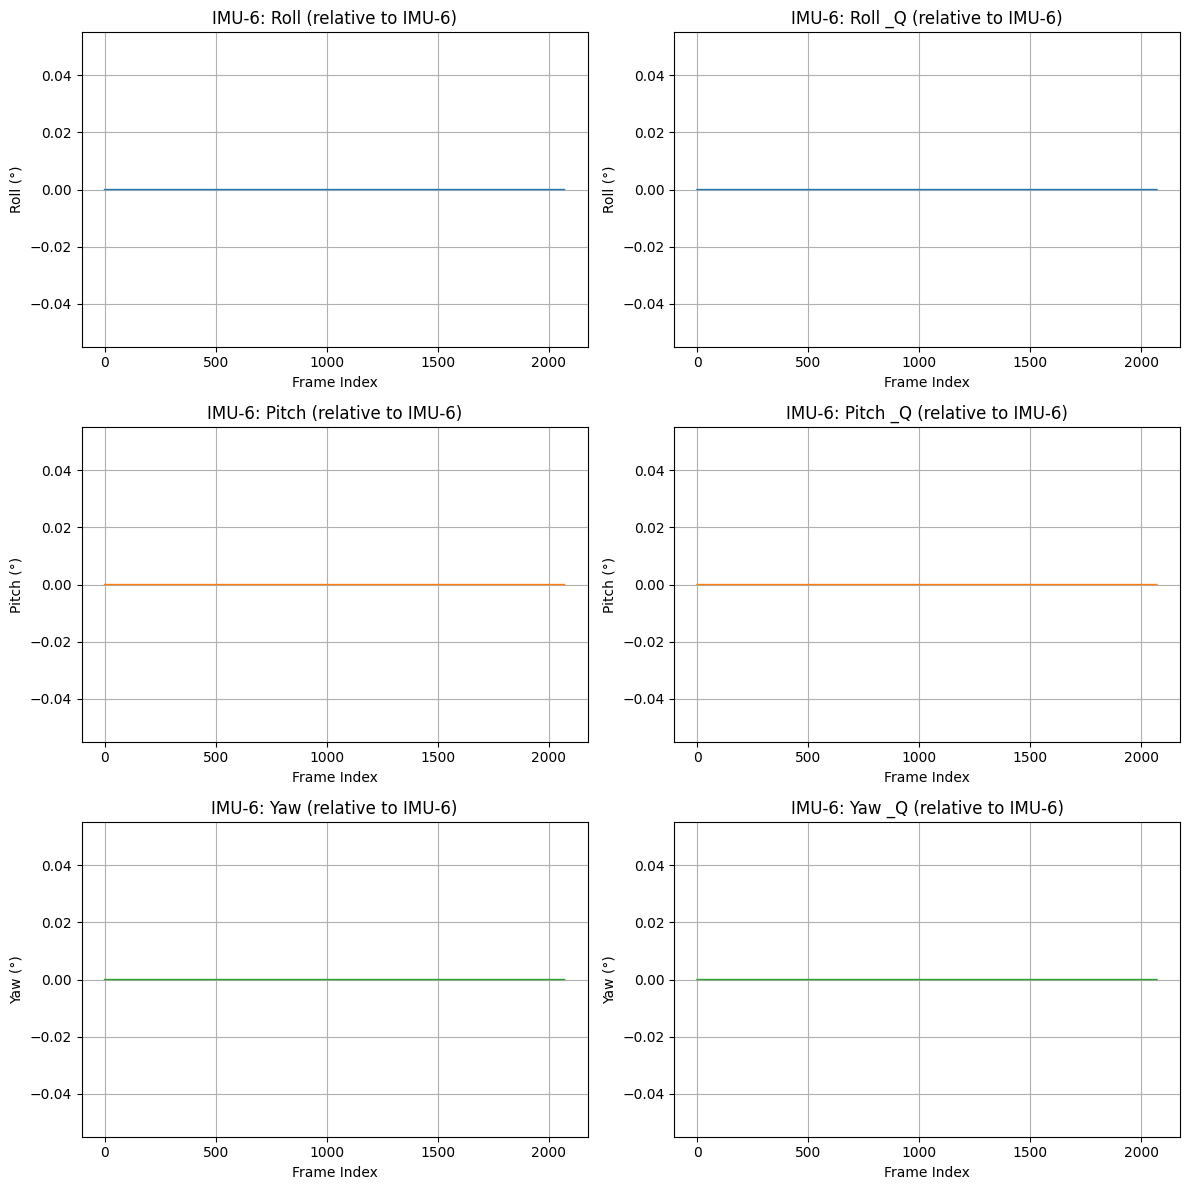

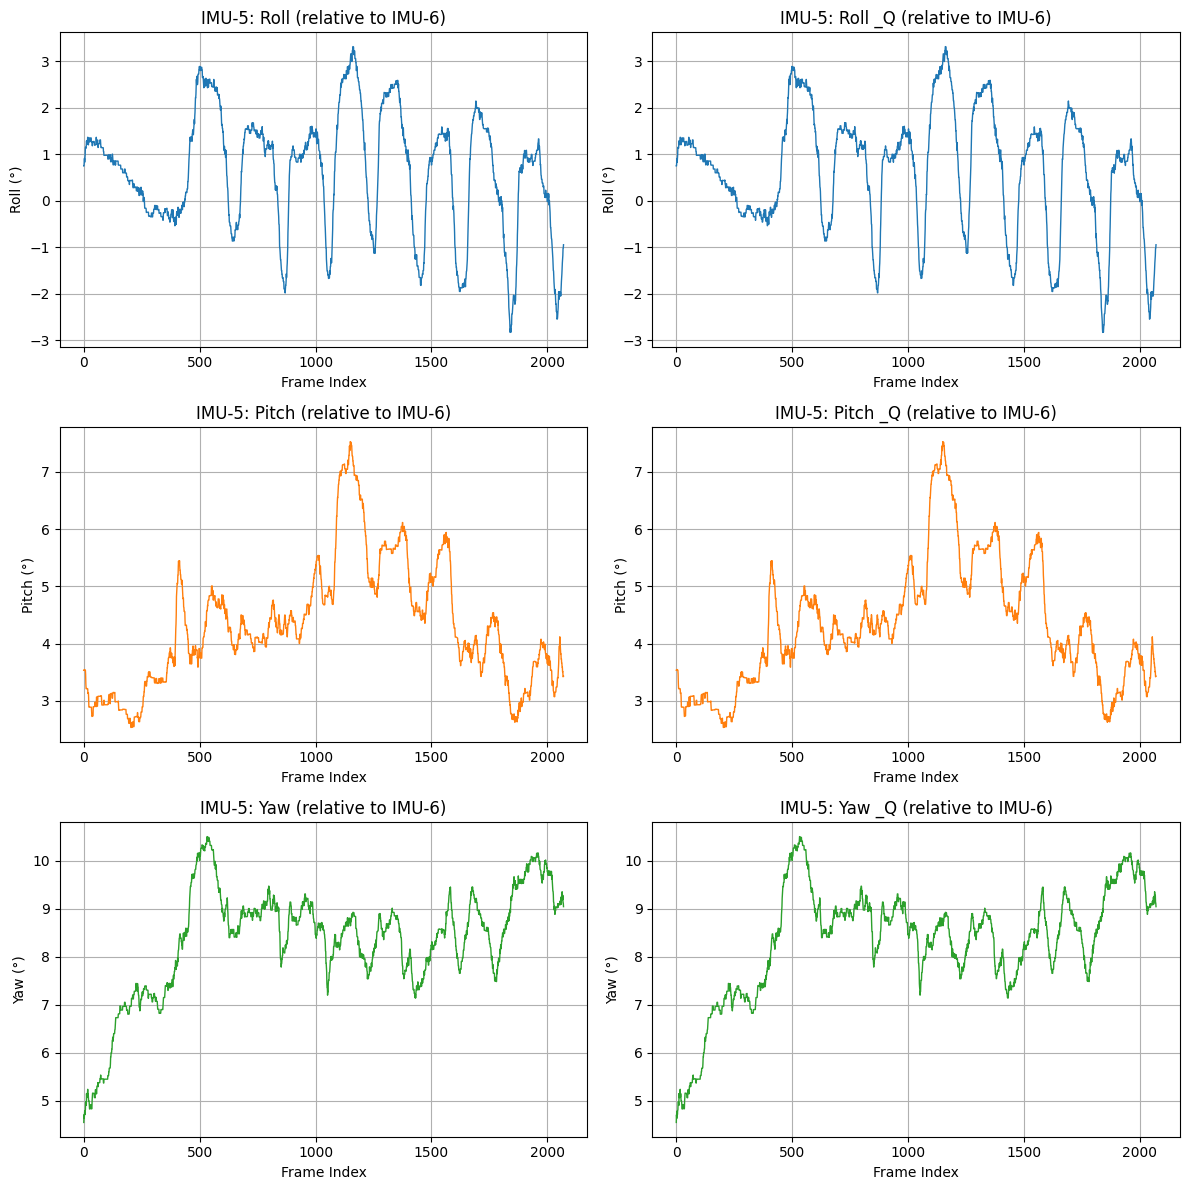

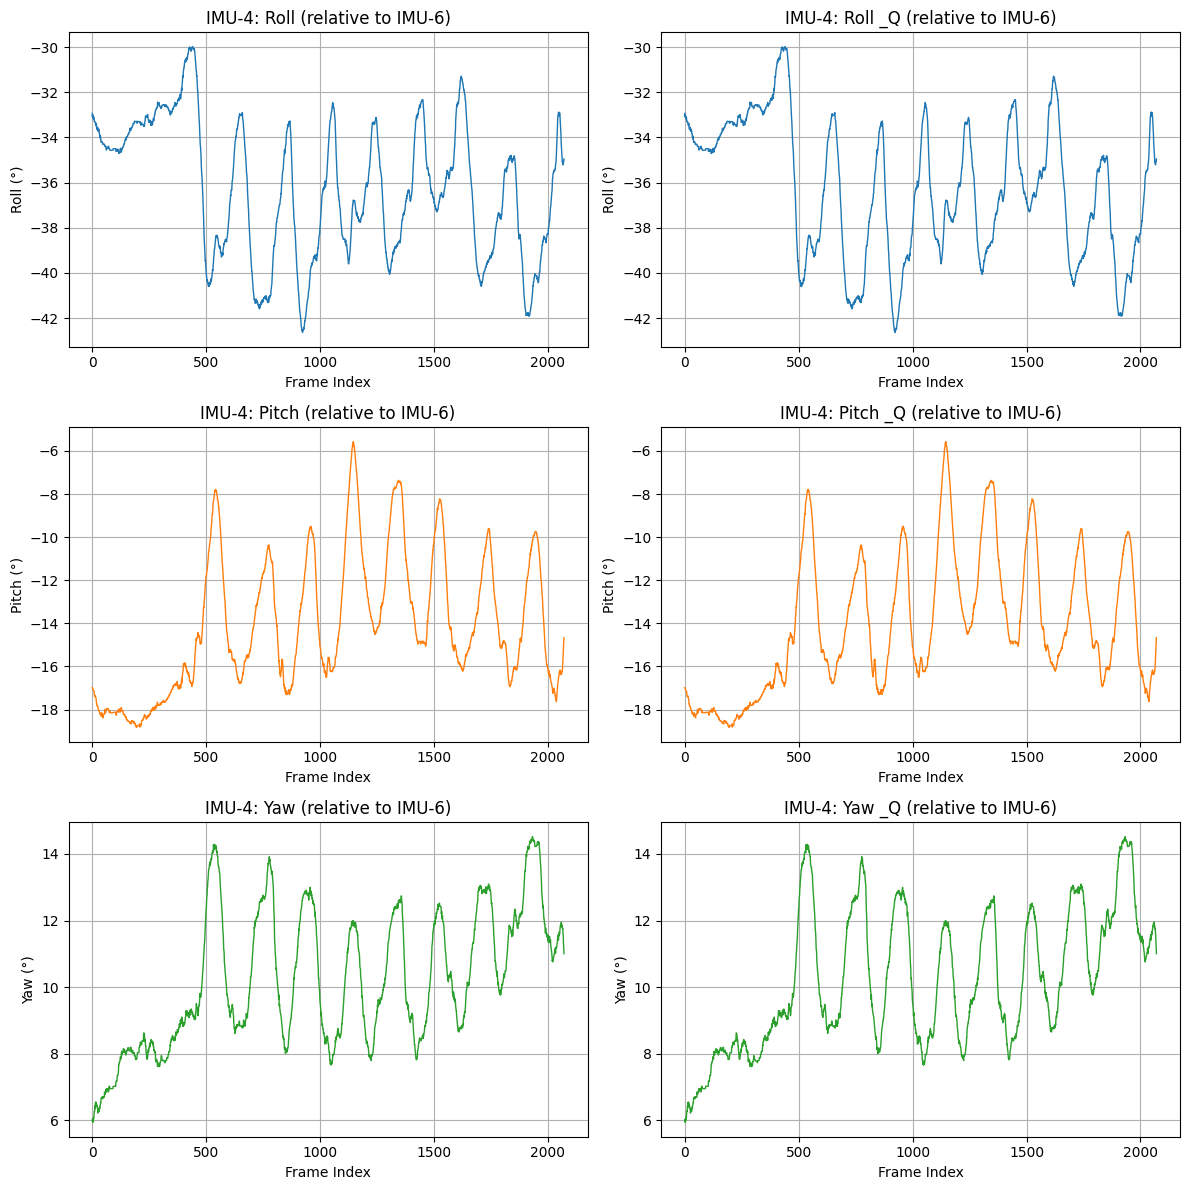

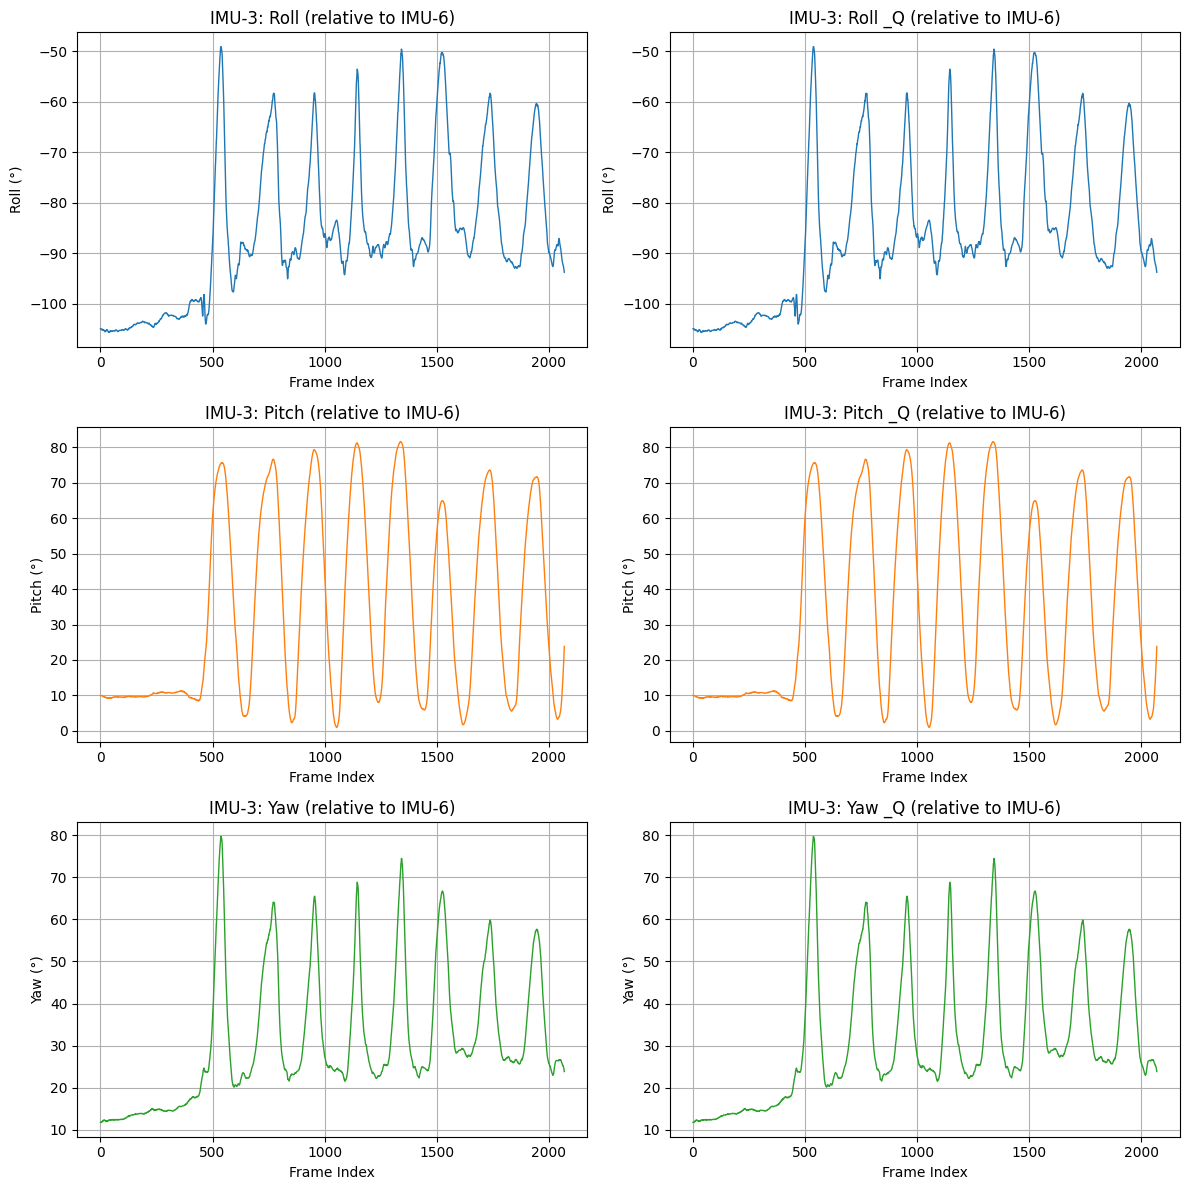

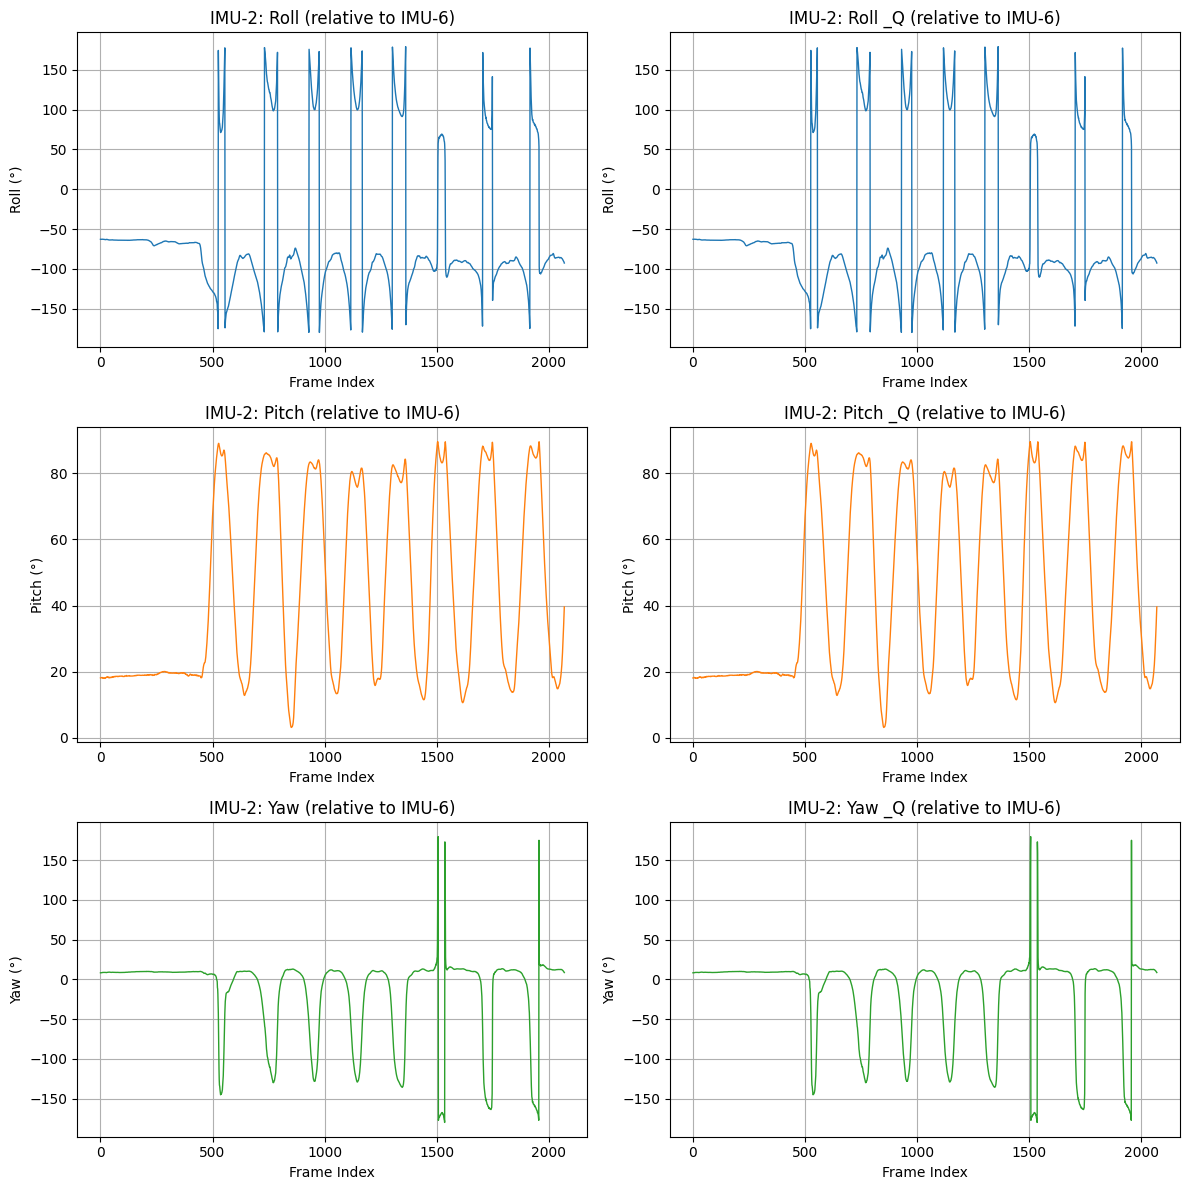

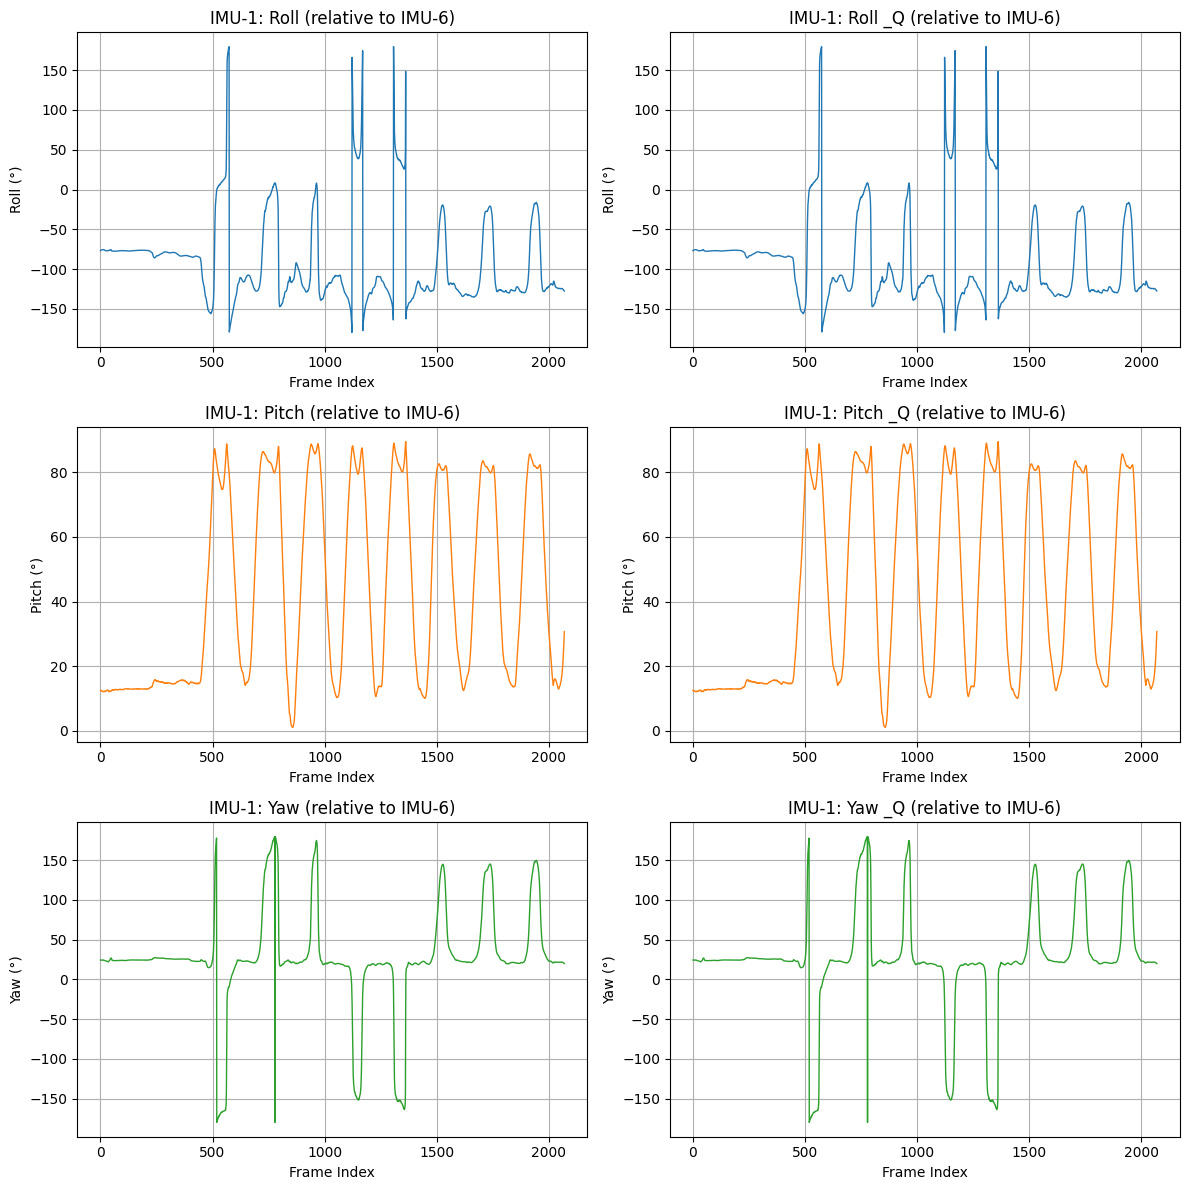

In [ ]:
# A list of dictionaries storing the skeleton node positions at each frame
positions_list = []
shoulder_vector_angle_subtraction  = np.full(num_frames, np.nan)
shoulder_vector_angle_    = np.full(num_frames, np.nan)

# Loop over all frames; compute positions and record joint angles
for frame in range(num_frames):
    
    
    v_chest = seg_pos["IMU-5"] - seg_pos["IMU-6"]
    v_upper = seg_pos["IMU-3"] - seg_pos["IMU-2"]
    shoulder_vector_angle_subtraction[frame]= angle_between(v_chest, v_upper)
    
    
   
        
    # Compute shoulder elevation/retraction from IMU-4 relative to IMU-5's local frame
        


In [61]:
a = np.array(seg_pos)
a.shape

()

In [63]:
seg_pos

{'ROOT': array([0., 0., 0.]),
 'IMU-6': array([-1.70717143e-03,  6.30393870e-06, -1.29588755e-01]),
 'IMU-5': array([-0.00241269,  0.00807828, -0.35624397]),
 'IMU-4': array([ 0.05522731, -0.10465459, -0.42705352]),
 'IMU-3': array([ 0.13260968, -0.15067313, -0.71460874]),
 'IMU-2': array([ 0.2066422 , -0.04904842, -0.91302652]),
 'IMU-1': array([ 0.21404854,  0.08717692, -1.02766963])}